In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sciopy import EIT_16_32_64_128, EitMeasurementSetup
import matplotlib.pyplot as plt

In [3]:
# create a 'sciospec' class which represents the sciospec EIT device
n_el = 32
sciospec = EIT_16_32_64_128(n_el)

In [9]:
# connect device via USB-HS port
sciospec.connect_device_HS()

Serial connection 'self.serial_protocol' already defined as {self.serial_protocol}.


In [10]:
# read system message buffer
sciospec.SystemMessageCallback()
# should be empty

In [11]:
# create a measurement setup
setup = EitMeasurementSetup(
    burst_count=5,
    n_el=n_el,
    exc_freq=125_000,
    framerate=3,
    amplitude=0.01,
    inj_skip=n_el // 2,
    gain=1,
    adc_range=1,
)

In [12]:
sciospec.SetMeasurementSetup(setup)

Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4
Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4
Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4
Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4


In [13]:
# get data
data = sciospec.StartStopMeasurement(return_as="pot_mat")  # or "hex"  # kommt in for schleife 

In [14]:
data.shape   #mitteln, 1-4 burst count für training, und 5. für test for pot in data:

(5, 32, 32)

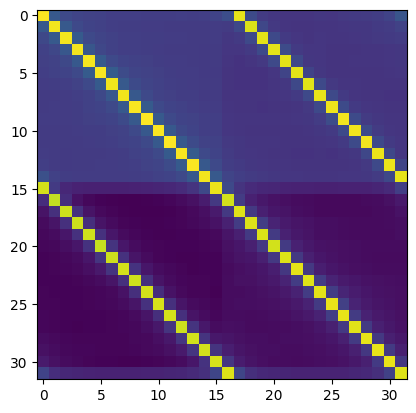

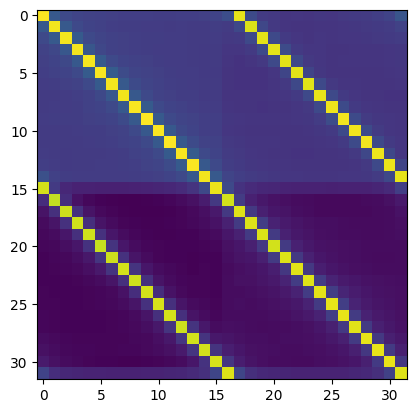

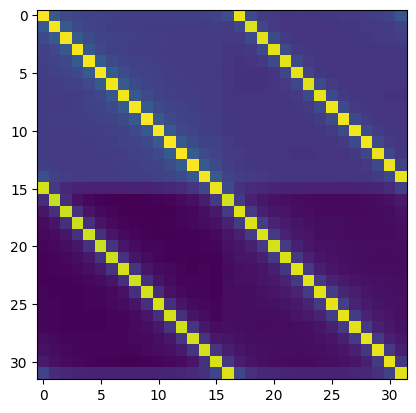

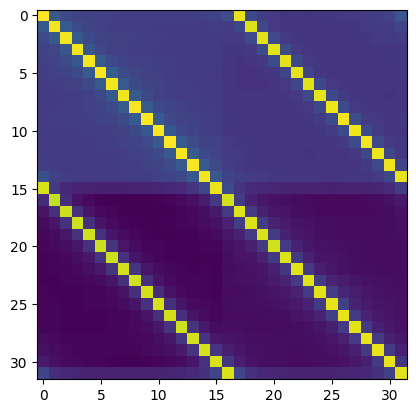

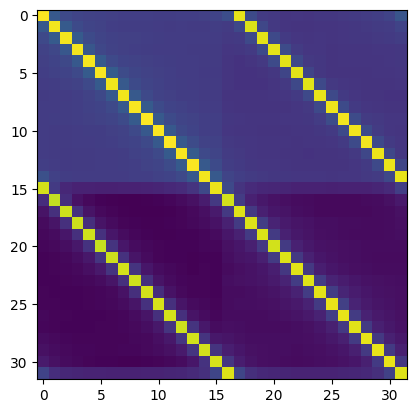

In [15]:
for pot in data:
    plt.imshow(np.abs(pot))
    plt.show()

In [16]:
import serial

from typing import Union
import time
from datetime import datetime
import numpy as np
import sys
import glob
from src.util import (
    create_trajectory
)
import os
from glob import glob
from tqdm import tqdm
# https://reprap.org/wiki/G-code#M17:_Enable.2FPower_all_stepper_motors

def command(ser, command) -> None:
    ser.write(str.encode(command))
    time.sleep(1)
    while True:
        line = ser.readline()
        print(line)

        if line == b"ok\n":
            break

# class
class EnderControl:
    def __init__(self,com_port, baudrate = 115200, timeout = 1, motion_speed = 1000):
        self.com_port = com_port
        self.baudrate = baudrate
        self.motion_speed = motion_speed # movement in mm/min
        self.position_timestamps = []  # Hier wird das Attribut position_timestamps korrekt initialisiert


    def connect(self):
        com = serial.Serial(
            port=self.com_port,
            baudrate=self.baudrate,
            parity=serial.PARITY_NONE,
            stopbits=serial.STOPBITS_ONE,
            bytesize=serial.EIGHTBITS,
        )
    
        print("Connection to", com.name, "is established.")
        self.com = com
        
    def init(self):
        """
        Initialise the axis
        """
        # x_y_home(ser)
        command(self.com, f"G28 X0 Y0 F{self.motion_speed}\r\n")
        command(self.com, f"G28 Z0 F{self.motion_speed}\r\n")
        self.x_y_center()
        self.turn_off_fan()
        print("X,Y axis are centered at X(180), Y(180)")

        return [180, 180]
    
    def turn_off_fan(self):
        command(self.com, "M106 S0\r\n")

    def x_y_center(self):
        command(self.com, f"G0 X180 Y180 F{self.motion_speed}\r\n")

    def move_to_absolute_x_y(self, P) -> None:
        command(
            self.com,
            f"G0 X{P[0]+180} Y{P[1]+180} F{self.motion_speed}\r\n",
        )
        pos = [P[0]+180, P[1]+180]
        return pos

    def read_temperature(self) -> float:
        """
        Read the bed temperature of the Ender 5.
    
        This function sends the M105 command, which requests the current temperature.
    
        Returns
        -------
        float
            The bed temperature value.
        """
    
        self.com.write(str.encode(f"M105\r\n"))
        time.sleep(1)
        line = self.com.readline()
        temp = float(str(line).split("B:")[1].split(" ")[0])
        
        return temp

    def get_timestamp(self) -> str:
        """
        Returns the current timestamp in the format YYYY-MM-DD HH:MM:SS
        """
        current_time = datetime.now()  # Get the current date and time
        formatted_timestamp = current_time.strftime("%Y-%m-%d %H:%M:%S")  # Format the timestamp
        return current_time, formatted_timestamp

In [17]:
printer = EnderControl(com_port="/dev/ttyUSB1")
printer.connect()

Connection to /dev/ttyUSB1 is established.


## Initializing Printer ##

In [22]:
printer.init()

b'echo:busy: processing\n'
b'echo:busy: processing\n'
b'echo:busy: processing\n'
b'echo:busy: processing\n'
b'X:360.00 Y:360.00 Z:10.00 E:0.00 Count X:28800 Y:28800 Z:8000\n'
b'ok\n'
b'echo:busy: processing\n'
b'echo:busy: processing\n'
b'echo:busy: processing\n'
b'echo:busy: processing\n'
b'echo:busy: processing\n'
b'echo:busy: processing\n'
b'echo:busy: processing\n'
b'echo:busy: processing\n'
b'X:180.00 Y:180.00 Z:10.00 E:0.00 Count X:14400 Y:14400 Z:8000\n'
b'ok\n'
b'ok\n'
b'ok\n'
X,Y axis are centered at X(180), Y(180)


[180, 180]

## Generating and saving data ##

In [23]:
def generate_exp_data(traj, r_path, r_anomaly, material, empty_tank_pos, empty_tank_timestamp, empty_tank_machine_time, empty_tank_temp, empty_tank_data, base_points=1000):

    ref_radius = 0.2
    scale_factor = r_path / ref_radius
    scaled_points = int(round(base_points * scale_factor))
    print(f"Generierte Punkte: {scaled_points} (Skalierung basierend auf r_path={r_path} und ref_radius={ref_radius})")
    center_pos = create_trajectory(traj, r_path * 97, scaled_points)  # Trajektorie mit der skalierten Punktzahl
    
    base_dataset_folder = "exp_data_set"
    os.makedirs(base_dataset_folder, exist_ok=True)
    
    # Bestimme den Ordnernamen
    base_name = "exp_data"
    counter = 1
    folder_name = os.path.join(base_dataset_folder, base_name)
    while os.path.exists(folder_name):
        folder_name = os.path.join(base_dataset_folder, f"{base_name}{counter}")
        counter += 1
    os.makedirs(folder_name)
    
    # Logge die Parameter
    lookup = {
        "folder": folder_name,
        "Trajectory": traj,
        "Nsteps": scaled_points,
        "r_anomaly": r_anomaly,
        "r_path": r_path,
        "material": material,
    }

    lookup_file_path = os.path.join(base_dataset_folder, "exp_data_log.txt")
    with open(lookup_file_path, 'a') as f:
        for key, value in lookup.items():
            f.write(f"{key}: {value}\n")
        f.write("-" * 40 + "\n")

    # Speichere die leeren Tankmessungen als ersten Datensatz
    file_path = os.path.join(folder_name, "sample_000000.npz")
    np.savez(file_path, position=empty_tank_pos, timestamp=empty_tank_timestamp, 
             machine_time=empty_tank_machine_time, temperature=empty_tank_temp, v=empty_tank_data)
    
    for save_index, Ps in tqdm(enumerate(center_pos), total=len(center_pos)): 
        pos = printer.move_to_absolute_x_y(Ps)  
        temp = printer.read_temperature()  
        machine_time, timestamp = printer.get_timestamp()  
        data = sciospec.StartStopMeasurement(return_as="pot_mat")  
        
        # Speichere die Messung (Start bei sample_000001.npz)
        file_path = os.path.join(folder_name, f"sample_{save_index + 1:06d}.npz")
        np.savez(file_path, position=pos, timestamp=timestamp, machine_time=machine_time, 
                 temperature=temp, v=data)

    print("Measurement is complete!")

def empty_tank_measure():
    """Erfasst die leeren Tankdaten."""
    pos = [180, 180]
    temp = printer.read_temperature()
    machine_time, timestamp = printer.get_timestamp()
    data = sciospec.StartStopMeasurement(return_as="pot_mat")
    return pos, timestamp, machine_time, temp, data

In [24]:
empty_tank_pos, empty_tank_timestamp, empty_tank_machine_time, empty_tank_temp, empty_tank_data = empty_tank_measure()

In [25]:
generate_exp_data(
    "Acht",           # Trajektorie
    0.2,              # r_path (Radius) 0.7, 0.6, 0.5, 0.4, 0.3, 0.2
    15,               # r_anomaly (Anomalieparameter)
    "Acryl Glas",     # Material
    empty_tank_pos,  
    empty_tank_timestamp,  
    empty_tank_machine_time,  
    empty_tank_temp,  
    empty_tank_data
)


Generierte Punkte: 1000 (Skalierung basierend auf r_path=0.2 und ref_radius=0.2)


  0%|                                                  | 0/1000 [00:00<?, ?it/s]

b'ok\n'


  0%|                                        | 1/1000 [00:04<1:16:39,  4.60s/it]

b'ok\n'


  0%|                                        | 2/1000 [00:09<1:16:40,  4.61s/it]

b'ok\n'


  0%|                                        | 3/1000 [00:13<1:16:36,  4.61s/it]

b'ok\n'


  0%|▏                                       | 4/1000 [00:18<1:16:32,  4.61s/it]

b'ok\n'


  0%|▏                                       | 5/1000 [00:23<1:16:26,  4.61s/it]

b'ok\n'


  1%|▏                                       | 6/1000 [00:27<1:16:19,  4.61s/it]

b'ok\n'


  1%|▎                                       | 7/1000 [00:32<1:16:09,  4.60s/it]

b'ok\n'


  1%|▎                                       | 8/1000 [00:36<1:16:07,  4.60s/it]

b'ok\n'


  1%|▎                                       | 9/1000 [00:41<1:16:03,  4.61s/it]

b'ok\n'


  1%|▍                                      | 10/1000 [00:46<1:16:00,  4.61s/it]

b'ok\n'


  1%|▍                                      | 11/1000 [00:50<1:15:47,  4.60s/it]

b'ok\n'


  1%|▍                                      | 12/1000 [00:55<1:15:39,  4.59s/it]

b'ok\n'


  1%|▌                                      | 13/1000 [00:59<1:15:35,  4.60s/it]

b'ok\n'


  1%|▌                                      | 14/1000 [01:04<1:15:38,  4.60s/it]

b'ok\n'


  2%|▌                                      | 15/1000 [01:09<1:15:36,  4.61s/it]

b'ok\n'


  2%|▌                                      | 16/1000 [01:13<1:15:32,  4.61s/it]

b'ok\n'


  2%|▋                                      | 17/1000 [01:18<1:15:28,  4.61s/it]

b'ok\n'


  2%|▋                                      | 18/1000 [01:22<1:15:25,  4.61s/it]

b'ok\n'


  2%|▋                                      | 19/1000 [01:27<1:15:22,  4.61s/it]

b'ok\n'


  2%|▊                                      | 20/1000 [01:32<1:15:18,  4.61s/it]

b'ok\n'


  2%|▊                                      | 21/1000 [01:36<1:15:14,  4.61s/it]

b'ok\n'


  2%|▊                                      | 22/1000 [01:41<1:15:11,  4.61s/it]

b'ok\n'


  2%|▉                                      | 23/1000 [01:45<1:15:06,  4.61s/it]

b'ok\n'


  2%|▉                                      | 24/1000 [01:50<1:15:00,  4.61s/it]

b'ok\n'


  2%|▉                                      | 25/1000 [01:55<1:14:54,  4.61s/it]

b'ok\n'


  3%|█                                      | 26/1000 [01:59<1:14:43,  4.60s/it]

b'ok\n'


  3%|█                                      | 27/1000 [02:04<1:14:40,  4.61s/it]

b'ok\n'


  3%|█                                      | 28/1000 [02:08<1:14:36,  4.60s/it]

b'ok\n'


  3%|█▏                                     | 29/1000 [02:13<1:14:33,  4.61s/it]

b'ok\n'


  3%|█▏                                     | 30/1000 [02:18<1:14:31,  4.61s/it]

b'ok\n'


  3%|█▏                                     | 31/1000 [02:22<1:14:23,  4.61s/it]

b'ok\n'


  3%|█▏                                     | 32/1000 [02:27<1:14:15,  4.60s/it]

b'ok\n'


  3%|█▎                                     | 33/1000 [02:32<1:14:14,  4.61s/it]

b'ok\n'


  3%|█▎                                     | 34/1000 [02:36<1:14:12,  4.61s/it]

b'ok\n'


  4%|█▎                                     | 35/1000 [02:41<1:14:05,  4.61s/it]

b'ok\n'


  4%|█▍                                     | 36/1000 [02:45<1:13:54,  4.60s/it]

b'ok\n'


  4%|█▍                                     | 37/1000 [02:50<1:13:44,  4.59s/it]

b'ok\n'


  4%|█▍                                     | 38/1000 [02:55<1:13:45,  4.60s/it]

b'ok\n'


  4%|█▌                                     | 39/1000 [02:59<1:13:44,  4.60s/it]

b'ok\n'


  4%|█▌                                     | 40/1000 [03:04<1:13:40,  4.60s/it]

b'ok\n'


  4%|█▌                                     | 41/1000 [03:08<1:13:37,  4.61s/it]

b'ok\n'


  4%|█▋                                     | 42/1000 [03:13<1:13:32,  4.61s/it]

b'ok\n'


  4%|█▋                                     | 43/1000 [03:18<1:13:27,  4.61s/it]

b'ok\n'


  4%|█▋                                     | 44/1000 [03:22<1:13:22,  4.61s/it]

b'ok\n'


  4%|█▊                                     | 45/1000 [03:27<1:13:19,  4.61s/it]

b'ok\n'


  5%|█▊                                     | 46/1000 [03:31<1:13:08,  4.60s/it]

b'ok\n'


  5%|█▊                                     | 47/1000 [03:36<1:13:06,  4.60s/it]

b'ok\n'


  5%|█▊                                     | 48/1000 [03:41<1:13:04,  4.61s/it]

b'ok\n'


  5%|█▉                                     | 49/1000 [03:45<1:13:03,  4.61s/it]

b'ok\n'


  5%|█▉                                     | 50/1000 [03:50<1:13:00,  4.61s/it]

b'ok\n'


  5%|█▉                                     | 51/1000 [03:54<1:12:53,  4.61s/it]

b'ok\n'


  5%|██                                     | 52/1000 [03:59<1:12:45,  4.60s/it]

b'ok\n'


  5%|██                                     | 53/1000 [04:04<1:12:43,  4.61s/it]

b'ok\n'


  5%|██                                     | 54/1000 [04:08<1:12:39,  4.61s/it]

b'ok\n'


  6%|██▏                                    | 55/1000 [04:13<1:12:33,  4.61s/it]

b'ok\n'


  6%|██▏                                    | 56/1000 [04:17<1:12:24,  4.60s/it]

b'ok\n'


  6%|██▏                                    | 57/1000 [04:22<1:12:18,  4.60s/it]

b'ok\n'


  6%|██▎                                    | 58/1000 [04:27<1:12:14,  4.60s/it]

b'ok\n'


  6%|██▎                                    | 59/1000 [04:31<1:12:11,  4.60s/it]

b'ok\n'


  6%|██▎                                    | 60/1000 [04:36<1:12:01,  4.60s/it]

b'ok\n'


  6%|██▍                                    | 61/1000 [04:40<1:11:54,  4.60s/it]

b'ok\n'


  6%|██▍                                    | 62/1000 [04:45<1:11:55,  4.60s/it]

b'ok\n'


  6%|██▍                                    | 63/1000 [04:50<1:11:51,  4.60s/it]

b'ok\n'


  6%|██▍                                    | 64/1000 [04:54<1:11:40,  4.59s/it]

b'ok\n'


  6%|██▌                                    | 65/1000 [04:59<1:11:41,  4.60s/it]

b'ok\n'


  7%|██▌                                    | 66/1000 [05:03<1:11:38,  4.60s/it]

b'ok\n'


  7%|██▌                                    | 67/1000 [05:08<1:11:36,  4.61s/it]

b'ok\n'


  7%|██▋                                    | 68/1000 [05:13<1:11:34,  4.61s/it]

b'ok\n'


  7%|██▋                                    | 69/1000 [05:17<1:11:32,  4.61s/it]

b'ok\n'


  7%|██▋                                    | 70/1000 [05:22<1:11:26,  4.61s/it]

b'ok\n'


  7%|██▊                                    | 71/1000 [05:26<1:11:07,  4.59s/it]

b'ok\n'


  7%|██▊                                    | 72/1000 [05:31<1:11:02,  4.59s/it]

b'ok\n'


  7%|██▊                                    | 73/1000 [05:36<1:11:02,  4.60s/it]

b'ok\n'


  7%|██▉                                    | 74/1000 [05:40<1:10:54,  4.59s/it]

b'ok\n'


  8%|██▉                                    | 75/1000 [05:45<1:10:55,  4.60s/it]

b'ok\n'


  8%|██▉                                    | 76/1000 [05:49<1:10:46,  4.60s/it]

b'ok\n'


  8%|███                                    | 77/1000 [05:54<1:10:46,  4.60s/it]

b'ok\n'


  8%|███                                    | 78/1000 [05:59<1:10:43,  4.60s/it]

b'ok\n'


  8%|███                                    | 79/1000 [06:03<1:10:42,  4.61s/it]

b'ok\n'


  8%|███                                    | 80/1000 [06:08<1:10:39,  4.61s/it]

b'ok\n'


  8%|███▏                                   | 81/1000 [06:12<1:10:35,  4.61s/it]

b'ok\n'


  8%|███▏                                   | 82/1000 [06:17<1:10:31,  4.61s/it]

b'ok\n'


  8%|███▏                                   | 83/1000 [06:22<1:10:26,  4.61s/it]

b'ok\n'


  8%|███▎                                   | 84/1000 [06:26<1:10:23,  4.61s/it]

b'ok\n'


  8%|███▎                                   | 85/1000 [06:31<1:10:18,  4.61s/it]

b'ok\n'


  9%|███▎                                   | 86/1000 [06:36<1:10:10,  4.61s/it]

b'ok\n'


  9%|███▍                                   | 87/1000 [06:40<1:10:08,  4.61s/it]

b'ok\n'


  9%|███▍                                   | 88/1000 [06:45<1:10:04,  4.61s/it]

b'ok\n'


  9%|███▍                                   | 89/1000 [06:49<1:10:00,  4.61s/it]

b'ok\n'


  9%|███▌                                   | 90/1000 [06:54<1:09:54,  4.61s/it]

b'ok\n'


  9%|███▌                                   | 91/1000 [06:59<1:09:43,  4.60s/it]

b'ok\n'


  9%|███▌                                   | 92/1000 [07:03<1:09:36,  4.60s/it]

b'ok\n'


  9%|███▋                                   | 93/1000 [07:08<1:09:27,  4.59s/it]

b'ok\n'


  9%|███▋                                   | 94/1000 [07:12<1:09:27,  4.60s/it]

b'ok\n'


 10%|███▋                                   | 95/1000 [07:17<1:09:25,  4.60s/it]

b'ok\n'


 10%|███▋                                   | 96/1000 [07:22<1:09:24,  4.61s/it]

b'ok\n'


 10%|███▊                                   | 97/1000 [07:26<1:09:21,  4.61s/it]

b'ok\n'


 10%|███▊                                   | 98/1000 [07:31<1:09:15,  4.61s/it]

b'ok\n'


 10%|███▊                                   | 99/1000 [07:35<1:09:12,  4.61s/it]

b'ok\n'


 10%|███▊                                  | 100/1000 [07:40<1:09:08,  4.61s/it]

b'ok\n'


 10%|███▊                                  | 101/1000 [07:45<1:09:00,  4.61s/it]

b'ok\n'


 10%|███▉                                  | 102/1000 [07:49<1:08:58,  4.61s/it]

b'ok\n'


 10%|███▉                                  | 103/1000 [07:54<1:08:47,  4.60s/it]

b'ok\n'


 10%|███▉                                  | 104/1000 [07:58<1:08:46,  4.61s/it]

b'ok\n'


 10%|███▉                                  | 105/1000 [08:03<1:08:41,  4.61s/it]

b'ok\n'


 11%|████                                  | 106/1000 [08:08<1:08:36,  4.60s/it]

b'ok\n'


 11%|████                                  | 107/1000 [08:12<1:08:34,  4.61s/it]

b'ok\n'


 11%|████                                  | 108/1000 [08:17<1:08:30,  4.61s/it]

b'ok\n'


 11%|████▏                                 | 109/1000 [08:21<1:08:27,  4.61s/it]

b'ok\n'


 11%|████▏                                 | 110/1000 [08:26<1:08:22,  4.61s/it]

b'ok\n'


 11%|████▏                                 | 111/1000 [08:31<1:08:19,  4.61s/it]

b'ok\n'


 11%|████▎                                 | 112/1000 [08:35<1:08:14,  4.61s/it]

b'ok\n'


 11%|████▎                                 | 113/1000 [08:40<1:08:03,  4.60s/it]

b'ok\n'


 11%|████▎                                 | 114/1000 [08:44<1:08:00,  4.61s/it]

b'ok\n'


 12%|████▎                                 | 115/1000 [08:49<1:07:57,  4.61s/it]

b'ok\n'


 12%|████▍                                 | 116/1000 [08:54<1:07:51,  4.61s/it]

b'ok\n'


 12%|████▍                                 | 117/1000 [08:58<1:07:44,  4.60s/it]

b'ok\n'


 12%|████▍                                 | 118/1000 [09:03<1:07:41,  4.61s/it]

b'ok\n'


 12%|████▌                                 | 119/1000 [09:08<1:07:39,  4.61s/it]

b'ok\n'


 12%|████▌                                 | 120/1000 [09:12<1:07:35,  4.61s/it]

b'ok\n'


 12%|████▌                                 | 121/1000 [09:17<1:07:23,  4.60s/it]

b'ok\n'


 12%|████▋                                 | 122/1000 [09:21<1:07:22,  4.60s/it]

b'ok\n'


 12%|████▋                                 | 123/1000 [09:26<1:07:20,  4.61s/it]

b'ok\n'


 12%|████▋                                 | 124/1000 [09:31<1:07:13,  4.60s/it]

b'ok\n'


 12%|████▊                                 | 125/1000 [09:35<1:07:08,  4.60s/it]

b'ok\n'


 13%|████▊                                 | 126/1000 [09:40<1:07:04,  4.60s/it]

b'ok\n'


 13%|████▊                                 | 127/1000 [09:44<1:07:03,  4.61s/it]

b'ok\n'


 13%|████▊                                 | 128/1000 [09:49<1:06:58,  4.61s/it]

b'ok\n'


 13%|████▉                                 | 129/1000 [09:54<1:06:53,  4.61s/it]

b'ok\n'


 13%|████▉                                 | 130/1000 [09:58<1:06:49,  4.61s/it]

b'ok\n'


 13%|████▉                                 | 131/1000 [10:03<1:06:39,  4.60s/it]

b'ok\n'


 13%|█████                                 | 132/1000 [10:07<1:06:37,  4.61s/it]

b'ok\n'


 13%|█████                                 | 133/1000 [10:12<1:06:25,  4.60s/it]

b'ok\n'


 13%|█████                                 | 134/1000 [10:17<1:06:17,  4.59s/it]

b'ok\n'


 14%|█████▏                                | 135/1000 [10:21<1:06:20,  4.60s/it]

b'ok\n'


 14%|█████▏                                | 136/1000 [10:26<1:06:16,  4.60s/it]

b'ok\n'


 14%|█████▏                                | 137/1000 [10:30<1:06:08,  4.60s/it]

b'ok\n'


 14%|█████▏                                | 138/1000 [10:35<1:06:08,  4.60s/it]

b'ok\n'


 14%|█████▎                                | 139/1000 [10:40<1:06:06,  4.61s/it]

b'ok\n'


 14%|█████▎                                | 140/1000 [10:44<1:06:00,  4.61s/it]

b'ok\n'


 14%|█████▎                                | 141/1000 [10:49<1:05:51,  4.60s/it]

b'ok\n'


 14%|█████▍                                | 142/1000 [10:53<1:05:51,  4.61s/it]

b'ok\n'


 14%|█████▍                                | 143/1000 [10:58<1:05:49,  4.61s/it]

b'ok\n'


 14%|█████▍                                | 144/1000 [11:03<1:05:47,  4.61s/it]

b'ok\n'


 14%|█████▌                                | 145/1000 [11:07<1:05:42,  4.61s/it]

b'ok\n'


 15%|█████▌                                | 146/1000 [11:12<1:05:38,  4.61s/it]

b'ok\n'


 15%|█████▌                                | 147/1000 [11:16<1:05:33,  4.61s/it]

b'ok\n'


 15%|█████▌                                | 148/1000 [11:21<1:05:26,  4.61s/it]

b'ok\n'


 15%|█████▋                                | 149/1000 [11:26<1:05:23,  4.61s/it]

b'ok\n'


 15%|█████▋                                | 150/1000 [11:30<1:05:12,  4.60s/it]

b'ok\n'


 15%|█████▋                                | 151/1000 [11:35<1:05:05,  4.60s/it]

b'ok\n'


 15%|█████▊                                | 152/1000 [11:39<1:05:02,  4.60s/it]

b'ok\n'


 15%|█████▊                                | 153/1000 [11:44<1:05:02,  4.61s/it]

b'ok\n'


 15%|█████▊                                | 154/1000 [11:49<1:04:50,  4.60s/it]

b'ok\n'


 16%|█████▉                                | 155/1000 [11:53<1:04:49,  4.60s/it]

b'ok\n'


 16%|█████▉                                | 156/1000 [11:58<1:04:43,  4.60s/it]

b'ok\n'


 16%|█████▉                                | 157/1000 [12:02<1:04:37,  4.60s/it]

b'ok\n'


 16%|██████                                | 158/1000 [12:07<1:04:36,  4.60s/it]

b'ok\n'


 16%|██████                                | 159/1000 [12:12<1:04:34,  4.61s/it]

b'ok\n'


 16%|██████                                | 160/1000 [12:16<1:04:29,  4.61s/it]

b'ok\n'


 16%|██████                                | 161/1000 [12:21<1:04:20,  4.60s/it]

b'ok\n'


 16%|██████▏                               | 162/1000 [12:25<1:04:15,  4.60s/it]

b'ok\n'


 16%|██████▏                               | 163/1000 [12:30<1:04:06,  4.60s/it]

b'ok\n'


 16%|██████▏                               | 164/1000 [12:35<1:04:05,  4.60s/it]

b'ok\n'


 16%|██████▎                               | 165/1000 [12:39<1:04:00,  4.60s/it]

b'ok\n'


 17%|██████▎                               | 166/1000 [12:44<1:03:59,  4.60s/it]

b'ok\n'


 17%|██████▎                               | 167/1000 [12:49<1:03:56,  4.61s/it]

b'ok\n'


 17%|██████▍                               | 168/1000 [12:53<1:03:51,  4.61s/it]

b'ok\n'


 17%|██████▍                               | 169/1000 [12:58<1:03:42,  4.60s/it]

b'ok\n'


 17%|██████▍                               | 170/1000 [13:02<1:03:33,  4.59s/it]

b'ok\n'


 17%|██████▍                               | 171/1000 [13:07<1:03:32,  4.60s/it]

b'ok\n'


 17%|██████▌                               | 172/1000 [13:12<1:03:30,  4.60s/it]

b'ok\n'


 17%|██████▌                               | 173/1000 [13:16<1:03:28,  4.61s/it]

b'ok\n'


 17%|██████▌                               | 174/1000 [13:21<1:03:21,  4.60s/it]

b'ok\n'


 18%|██████▋                               | 175/1000 [13:25<1:03:12,  4.60s/it]

b'ok\n'


 18%|██████▋                               | 176/1000 [13:30<1:03:11,  4.60s/it]

b'ok\n'


 18%|██████▋                               | 177/1000 [13:35<1:03:10,  4.61s/it]

b'ok\n'


 18%|██████▊                               | 178/1000 [13:39<1:03:06,  4.61s/it]

b'ok\n'


 18%|██████▊                               | 179/1000 [13:44<1:03:01,  4.61s/it]

b'ok\n'


 18%|██████▊                               | 180/1000 [13:48<1:02:58,  4.61s/it]

b'ok\n'


 18%|██████▉                               | 181/1000 [13:53<1:02:55,  4.61s/it]

b'ok\n'


 18%|██████▉                               | 182/1000 [13:58<1:02:50,  4.61s/it]

b'ok\n'


 18%|██████▉                               | 183/1000 [14:02<1:02:45,  4.61s/it]

b'ok\n'


 18%|██████▉                               | 184/1000 [14:07<1:02:41,  4.61s/it]

b'ok\n'


 18%|███████                               | 185/1000 [14:11<1:02:38,  4.61s/it]

b'ok\n'


 19%|███████                               | 186/1000 [14:16<1:02:25,  4.60s/it]

b'ok\n'


 19%|███████                               | 187/1000 [14:21<1:02:09,  4.59s/it]

b'ok\n'


 19%|███████▏                              | 188/1000 [14:25<1:02:05,  4.59s/it]

b'ok\n'


 19%|███████▏                              | 189/1000 [14:30<1:01:59,  4.59s/it]

b'ok\n'


 19%|███████▏                              | 190/1000 [14:34<1:02:00,  4.59s/it]

b'ok\n'


 19%|███████▎                              | 191/1000 [14:39<1:01:57,  4.60s/it]

b'ok\n'


 19%|███████▎                              | 192/1000 [14:44<1:01:56,  4.60s/it]

b'ok\n'


 19%|███████▎                              | 193/1000 [14:48<1:01:48,  4.60s/it]

b'ok\n'


 19%|███████▎                              | 194/1000 [14:53<1:01:47,  4.60s/it]

b'ok\n'


 20%|███████▍                              | 195/1000 [14:57<1:01:44,  4.60s/it]

b'ok\n'


 20%|███████▍                              | 196/1000 [15:02<1:01:42,  4.61s/it]

b'ok\n'


 20%|███████▍                              | 197/1000 [15:07<1:01:41,  4.61s/it]

b'ok\n'


 20%|███████▌                              | 198/1000 [15:11<1:01:30,  4.60s/it]

b'ok\n'


 20%|███████▌                              | 199/1000 [15:16<1:01:28,  4.61s/it]

b'ok\n'


 20%|███████▌                              | 200/1000 [15:20<1:01:18,  4.60s/it]

b'ok\n'


 20%|███████▋                              | 201/1000 [15:25<1:01:16,  4.60s/it]

b'ok\n'


 20%|███████▋                              | 202/1000 [15:30<1:01:13,  4.60s/it]

b'ok\n'


 20%|███████▋                              | 203/1000 [15:34<1:01:06,  4.60s/it]

b'ok\n'


 20%|███████▊                              | 204/1000 [15:39<1:01:05,  4.61s/it]

b'ok\n'


 20%|███████▊                              | 205/1000 [15:43<1:01:00,  4.60s/it]

b'ok\n'


 21%|███████▊                              | 206/1000 [15:48<1:00:57,  4.61s/it]

b'ok\n'


 21%|███████▊                              | 207/1000 [15:53<1:00:46,  4.60s/it]

b'ok\n'


 21%|███████▉                              | 208/1000 [15:57<1:00:45,  4.60s/it]

b'ok\n'


 21%|███████▉                              | 209/1000 [16:02<1:00:42,  4.61s/it]

b'ok\n'


 21%|███████▉                              | 210/1000 [16:06<1:00:38,  4.61s/it]

b'ok\n'


 21%|████████                              | 211/1000 [16:11<1:00:35,  4.61s/it]

b'ok\n'


 21%|████████                              | 212/1000 [16:16<1:00:32,  4.61s/it]

b'ok\n'


 21%|████████                              | 213/1000 [16:20<1:00:26,  4.61s/it]

b'ok\n'


 21%|████████▏                             | 214/1000 [16:25<1:00:22,  4.61s/it]

b'ok\n'


 22%|████████▏                             | 215/1000 [16:29<1:00:19,  4.61s/it]

b'ok\n'


 22%|████████▏                             | 216/1000 [16:34<1:00:16,  4.61s/it]

b'ok\n'


 22%|████████▏                             | 217/1000 [16:39<1:00:03,  4.60s/it]

b'ok\n'


 22%|████████▋                               | 218/1000 [16:43<59:53,  4.60s/it]

b'ok\n'


 22%|████████▊                               | 219/1000 [16:48<59:53,  4.60s/it]

b'ok\n'


 22%|████████▊                               | 220/1000 [16:52<59:50,  4.60s/it]

b'ok\n'


 22%|████████▊                               | 221/1000 [16:57<59:47,  4.61s/it]

b'ok\n'


 22%|████████▉                               | 222/1000 [17:02<59:43,  4.61s/it]

b'ok\n'


 22%|████████▉                               | 223/1000 [17:06<59:34,  4.60s/it]

b'ok\n'


 22%|████████▉                               | 224/1000 [17:11<59:33,  4.61s/it]

b'ok\n'


 22%|█████████                               | 225/1000 [17:15<59:30,  4.61s/it]

b'ok\n'


 23%|█████████                               | 226/1000 [17:20<59:27,  4.61s/it]

b'ok\n'


 23%|█████████                               | 227/1000 [17:25<59:25,  4.61s/it]

b'ok\n'


 23%|█████████                               | 228/1000 [17:29<59:14,  4.60s/it]

b'ok\n'


 23%|█████████▏                              | 229/1000 [17:34<59:11,  4.61s/it]

b'ok\n'


 23%|█████████▏                              | 230/1000 [17:39<59:02,  4.60s/it]

b'ok\n'


 23%|█████████▏                              | 231/1000 [17:43<59:02,  4.61s/it]

b'ok\n'


 23%|█████████▎                              | 232/1000 [17:48<58:58,  4.61s/it]

b'ok\n'


 23%|█████████▎                              | 233/1000 [17:52<58:53,  4.61s/it]

b'ok\n'


 23%|█████████▎                              | 234/1000 [17:57<58:49,  4.61s/it]

b'ok\n'


 24%|█████████▍                              | 235/1000 [18:02<58:46,  4.61s/it]

b'ok\n'


 24%|█████████▍                              | 236/1000 [18:06<58:40,  4.61s/it]

b'ok\n'


 24%|█████████▍                              | 237/1000 [18:11<58:37,  4.61s/it]

b'ok\n'


 24%|█████████▌                              | 238/1000 [18:15<58:33,  4.61s/it]

b'ok\n'


 24%|█████████▌                              | 239/1000 [18:20<58:31,  4.61s/it]

b'ok\n'


 24%|█████████▌                              | 240/1000 [18:25<58:25,  4.61s/it]

b'ok\n'


 24%|█████████▋                              | 241/1000 [18:29<58:14,  4.60s/it]

b'ok\n'


 24%|█████████▋                              | 242/1000 [18:34<58:12,  4.61s/it]

b'ok\n'


 24%|█████████▋                              | 243/1000 [18:38<58:08,  4.61s/it]

b'ok\n'


 24%|█████████▊                              | 244/1000 [18:43<58:03,  4.61s/it]

b'ok\n'


 24%|█████████▊                              | 245/1000 [18:48<57:58,  4.61s/it]

b'ok\n'


 25%|█████████▊                              | 246/1000 [18:52<57:56,  4.61s/it]

b'ok\n'


 25%|█████████▉                              | 247/1000 [18:57<57:51,  4.61s/it]

b'ok\n'


 25%|█████████▉                              | 248/1000 [19:01<57:41,  4.60s/it]

b'ok\n'


 25%|█████████▉                              | 249/1000 [19:06<57:34,  4.60s/it]

b'ok\n'


 25%|██████████                              | 250/1000 [19:11<57:31,  4.60s/it]

b'ok\n'


 25%|██████████                              | 251/1000 [19:15<57:28,  4.60s/it]

b'ok\n'


 25%|██████████                              | 252/1000 [19:20<57:24,  4.60s/it]

b'ok\n'


 25%|██████████                              | 253/1000 [19:24<57:19,  4.60s/it]

b'ok\n'


 25%|██████████▏                             | 254/1000 [19:29<57:18,  4.61s/it]

b'ok\n'


 26%|██████████▏                             | 255/1000 [19:34<57:14,  4.61s/it]

b'ok\n'


 26%|██████████▏                             | 256/1000 [19:38<57:08,  4.61s/it]

b'ok\n'


 26%|██████████▎                             | 257/1000 [19:43<57:05,  4.61s/it]

b'ok\n'


 26%|██████████▎                             | 258/1000 [19:48<57:00,  4.61s/it]

b'ok\n'


 26%|██████████▎                             | 259/1000 [19:52<56:57,  4.61s/it]

b'ok\n'


 26%|██████████▍                             | 260/1000 [19:57<56:52,  4.61s/it]

b'ok\n'


 26%|██████████▍                             | 261/1000 [20:01<56:48,  4.61s/it]

b'ok\n'


 26%|██████████▍                             | 262/1000 [20:06<56:43,  4.61s/it]

b'ok\n'


 26%|██████████▌                             | 263/1000 [20:11<56:32,  4.60s/it]

b'ok\n'


 26%|██████████▌                             | 264/1000 [20:15<56:30,  4.61s/it]

b'ok\n'


 26%|██████████▌                             | 265/1000 [20:20<56:27,  4.61s/it]

b'ok\n'


 27%|██████████▋                             | 266/1000 [20:24<56:23,  4.61s/it]

b'ok\n'


 27%|██████████▋                             | 267/1000 [20:29<56:18,  4.61s/it]

b'ok\n'


 27%|██████████▋                             | 268/1000 [20:34<56:14,  4.61s/it]

b'ok\n'


 27%|██████████▊                             | 269/1000 [20:38<56:04,  4.60s/it]

b'ok\n'


 27%|██████████▊                             | 270/1000 [20:43<55:55,  4.60s/it]

b'ok\n'


 27%|██████████▊                             | 271/1000 [20:47<55:52,  4.60s/it]

b'ok\n'


 27%|██████████▉                             | 272/1000 [20:52<55:50,  4.60s/it]

b'ok\n'


 27%|██████████▉                             | 273/1000 [20:57<55:42,  4.60s/it]

b'ok\n'


 27%|██████████▉                             | 274/1000 [21:01<55:42,  4.60s/it]

b'ok\n'


 28%|███████████                             | 275/1000 [21:06<55:36,  4.60s/it]

b'ok\n'


 28%|███████████                             | 276/1000 [21:10<55:31,  4.60s/it]

b'ok\n'


 28%|███████████                             | 277/1000 [21:15<55:29,  4.61s/it]

b'ok\n'


 28%|███████████                             | 278/1000 [21:20<55:24,  4.61s/it]

b'ok\n'


 28%|███████████▏                            | 279/1000 [21:24<55:21,  4.61s/it]

b'ok\n'


 28%|███████████▏                            | 280/1000 [21:29<55:18,  4.61s/it]

b'ok\n'


 28%|███████████▏                            | 281/1000 [21:33<55:14,  4.61s/it]

b'ok\n'


 28%|███████████▎                            | 282/1000 [21:38<55:07,  4.61s/it]

b'ok\n'


 28%|███████████▎                            | 283/1000 [21:43<54:59,  4.60s/it]

b'ok\n'


 28%|███████████▎                            | 284/1000 [21:47<54:54,  4.60s/it]

b'ok\n'


 28%|███████████▍                            | 285/1000 [21:52<54:50,  4.60s/it]

b'ok\n'


 29%|███████████▍                            | 286/1000 [21:56<54:48,  4.61s/it]

b'ok\n'


 29%|███████████▍                            | 287/1000 [22:01<54:45,  4.61s/it]

b'ok\n'


 29%|███████████▌                            | 288/1000 [22:06<54:37,  4.60s/it]

b'ok\n'


 29%|███████████▌                            | 289/1000 [22:10<54:33,  4.60s/it]

b'ok\n'


 29%|███████████▌                            | 290/1000 [22:15<54:24,  4.60s/it]

b'ok\n'


 29%|███████████▋                            | 291/1000 [22:19<54:23,  4.60s/it]

b'ok\n'


 29%|███████████▋                            | 292/1000 [22:24<54:20,  4.61s/it]

b'ok\n'


 29%|███████████▋                            | 293/1000 [22:29<54:11,  4.60s/it]

b'ok\n'


 29%|███████████▊                            | 294/1000 [22:33<54:09,  4.60s/it]

b'ok\n'


 30%|███████████▊                            | 295/1000 [22:38<54:07,  4.61s/it]

b'ok\n'


 30%|███████████▊                            | 296/1000 [22:43<54:04,  4.61s/it]

b'ok\n'


 30%|███████████▉                            | 297/1000 [22:47<53:59,  4.61s/it]

b'ok\n'


 30%|███████████▉                            | 298/1000 [22:52<53:55,  4.61s/it]

b'ok\n'


 30%|███████████▉                            | 299/1000 [22:56<53:47,  4.60s/it]

b'ok\n'


 30%|████████████                            | 300/1000 [23:01<53:42,  4.60s/it]

b'ok\n'


 30%|████████████                            | 301/1000 [23:06<53:39,  4.61s/it]

b'ok\n'


 30%|████████████                            | 302/1000 [23:10<53:34,  4.61s/it]

b'ok\n'


 30%|████████████                            | 303/1000 [23:15<53:25,  4.60s/it]

b'ok\n'


 30%|████████████▏                           | 304/1000 [23:19<53:24,  4.60s/it]

b'ok\n'


 30%|████████████▏                           | 305/1000 [23:24<53:20,  4.61s/it]

b'ok\n'


 31%|████████████▏                           | 306/1000 [23:29<53:18,  4.61s/it]

b'ok\n'


 31%|████████████▎                           | 307/1000 [23:33<53:09,  4.60s/it]

b'ok\n'


 31%|████████████▎                           | 308/1000 [23:38<52:57,  4.59s/it]

b'ok\n'


 31%|████████████▎                           | 309/1000 [23:42<52:57,  4.60s/it]

b'ok\n'


 31%|████████████▍                           | 310/1000 [23:47<52:55,  4.60s/it]

b'ok\n'


 31%|████████████▍                           | 311/1000 [23:52<52:53,  4.61s/it]

b'ok\n'


 31%|████████████▍                           | 312/1000 [23:56<52:44,  4.60s/it]

b'ok\n'


 31%|████████████▌                           | 313/1000 [24:01<52:40,  4.60s/it]

b'ok\n'


 31%|████████████▌                           | 314/1000 [24:05<52:38,  4.60s/it]

b'ok\n'


 32%|████████████▌                           | 315/1000 [24:10<52:35,  4.61s/it]

b'ok\n'


 32%|████████████▋                           | 316/1000 [24:15<52:31,  4.61s/it]

b'ok\n'


 32%|████████████▋                           | 317/1000 [24:19<52:20,  4.60s/it]

b'ok\n'


 32%|████████████▋                           | 318/1000 [24:24<52:17,  4.60s/it]

b'ok\n'


 32%|████████████▊                           | 319/1000 [24:28<52:16,  4.61s/it]

b'ok\n'


 32%|████████████▊                           | 320/1000 [24:33<52:12,  4.61s/it]

b'ok\n'


 32%|████████████▊                           | 321/1000 [24:38<52:09,  4.61s/it]

b'ok\n'


 32%|████████████▉                           | 322/1000 [24:42<52:06,  4.61s/it]

b'ok\n'


 32%|████████████▉                           | 323/1000 [24:47<52:01,  4.61s/it]

b'ok\n'


 32%|████████████▉                           | 324/1000 [24:51<51:54,  4.61s/it]

b'ok\n'


 32%|█████████████                           | 325/1000 [24:56<51:51,  4.61s/it]

b'ok\n'


 33%|█████████████                           | 326/1000 [25:01<51:45,  4.61s/it]

b'ok\n'


 33%|█████████████                           | 327/1000 [25:05<51:41,  4.61s/it]

b'ok\n'


 33%|█████████████                           | 328/1000 [25:10<51:32,  4.60s/it]

b'ok\n'


 33%|█████████████▏                          | 329/1000 [25:14<51:29,  4.60s/it]

b'ok\n'


 33%|█████████████▏                          | 330/1000 [25:19<51:27,  4.61s/it]

b'ok\n'


 33%|█████████████▏                          | 331/1000 [25:24<51:23,  4.61s/it]

b'ok\n'


 33%|█████████████▎                          | 332/1000 [25:28<51:16,  4.60s/it]

b'ok\n'


 33%|█████████████▎                          | 333/1000 [25:33<51:07,  4.60s/it]

b'ok\n'


 33%|█████████████▎                          | 334/1000 [25:37<51:03,  4.60s/it]

b'ok\n'


 34%|█████████████▍                          | 335/1000 [25:42<51:00,  4.60s/it]

b'ok\n'


 34%|█████████████▍                          | 336/1000 [25:47<50:56,  4.60s/it]

b'ok\n'


 34%|█████████████▍                          | 337/1000 [25:51<50:54,  4.61s/it]

b'ok\n'


 34%|█████████████▌                          | 338/1000 [25:56<50:45,  4.60s/it]

b'ok\n'


 34%|█████████████▌                          | 339/1000 [26:01<50:42,  4.60s/it]

b'ok\n'


 34%|█████████████▌                          | 340/1000 [26:05<50:38,  4.60s/it]

b'ok\n'


 34%|█████████████▋                          | 341/1000 [26:10<50:36,  4.61s/it]

b'ok\n'


 34%|█████████████▋                          | 342/1000 [26:14<50:33,  4.61s/it]

b'ok\n'


 34%|█████████████▋                          | 343/1000 [26:19<50:20,  4.60s/it]

b'ok\n'


 34%|█████████████▊                          | 344/1000 [26:24<50:14,  4.60s/it]

b'ok\n'


 34%|█████████████▊                          | 345/1000 [26:28<50:12,  4.60s/it]

b'ok\n'


 35%|█████████████▊                          | 346/1000 [26:33<50:06,  4.60s/it]

b'ok\n'


 35%|█████████████▉                          | 347/1000 [26:37<50:02,  4.60s/it]

b'ok\n'


 35%|█████████████▉                          | 348/1000 [26:42<49:59,  4.60s/it]

b'ok\n'


 35%|█████████████▉                          | 349/1000 [26:47<49:57,  4.60s/it]

b'ok\n'


 35%|██████████████                          | 350/1000 [26:51<49:53,  4.61s/it]

b'ok\n'


 35%|██████████████                          | 351/1000 [26:56<49:49,  4.61s/it]

b'ok\n'


 35%|██████████████                          | 352/1000 [27:00<49:44,  4.61s/it]

b'ok\n'


 35%|██████████████                          | 353/1000 [27:05<49:40,  4.61s/it]

b'ok\n'


 35%|██████████████▏                         | 354/1000 [27:10<49:31,  4.60s/it]

b'ok\n'


 36%|██████████████▏                         | 355/1000 [27:14<49:23,  4.59s/it]

b'ok\n'


 36%|██████████████▏                         | 356/1000 [27:19<49:22,  4.60s/it]

b'ok\n'


 36%|██████████████▎                         | 357/1000 [27:23<49:20,  4.60s/it]

b'ok\n'


 36%|██████████████▎                         | 358/1000 [27:28<49:17,  4.61s/it]

b'ok\n'


 36%|██████████████▎                         | 359/1000 [27:33<49:13,  4.61s/it]

b'ok\n'


 36%|██████████████▍                         | 360/1000 [27:37<49:03,  4.60s/it]

b'ok\n'


 36%|██████████████▍                         | 361/1000 [27:42<49:02,  4.60s/it]

b'ok\n'


 36%|██████████████▍                         | 362/1000 [27:46<48:57,  4.60s/it]

b'ok\n'


 36%|██████████████▌                         | 363/1000 [27:51<48:53,  4.60s/it]

b'ok\n'


 36%|██████████████▌                         | 364/1000 [27:56<48:50,  4.61s/it]

b'ok\n'


 36%|██████████████▌                         | 365/1000 [28:00<48:48,  4.61s/it]

b'ok\n'


 37%|██████████████▋                         | 366/1000 [28:05<48:42,  4.61s/it]

b'ok\n'


 37%|██████████████▋                         | 367/1000 [28:09<48:34,  4.60s/it]

b'ok\n'


 37%|██████████████▋                         | 368/1000 [28:14<48:29,  4.60s/it]

b'ok\n'


 37%|██████████████▊                         | 369/1000 [28:19<48:28,  4.61s/it]

b'ok\n'


 37%|██████████████▊                         | 370/1000 [28:23<48:21,  4.61s/it]

b'ok\n'


 37%|██████████████▊                         | 371/1000 [28:28<48:18,  4.61s/it]

b'ok\n'


 37%|██████████████▉                         | 372/1000 [28:32<48:14,  4.61s/it]

b'ok\n'


 37%|██████████████▉                         | 373/1000 [28:37<48:05,  4.60s/it]

b'ok\n'


 37%|██████████████▉                         | 374/1000 [28:42<48:02,  4.61s/it]

b'ok\n'


 38%|███████████████                         | 375/1000 [28:46<47:58,  4.61s/it]

b'ok\n'


 38%|███████████████                         | 376/1000 [28:51<47:51,  4.60s/it]

b'ok\n'


 38%|███████████████                         | 377/1000 [28:55<47:49,  4.61s/it]

b'ok\n'


 38%|███████████████                         | 378/1000 [29:00<47:44,  4.61s/it]

b'ok\n'


 38%|███████████████▏                        | 379/1000 [29:05<47:41,  4.61s/it]

b'ok\n'


 38%|███████████████▏                        | 380/1000 [29:09<47:38,  4.61s/it]

b'ok\n'


 38%|███████████████▏                        | 381/1000 [29:14<47:33,  4.61s/it]

b'ok\n'


 38%|███████████████▎                        | 382/1000 [29:19<47:25,  4.60s/it]

b'ok\n'


 38%|███████████████▎                        | 383/1000 [29:23<47:19,  4.60s/it]

b'ok\n'


 38%|███████████████▎                        | 384/1000 [29:28<47:17,  4.61s/it]

b'ok\n'


 38%|███████████████▍                        | 385/1000 [29:32<47:14,  4.61s/it]

b'ok\n'


 39%|███████████████▍                        | 386/1000 [29:37<47:09,  4.61s/it]

b'ok\n'


 39%|███████████████▍                        | 387/1000 [29:42<47:07,  4.61s/it]

b'ok\n'


 39%|███████████████▌                        | 388/1000 [29:46<47:02,  4.61s/it]

b'ok\n'


 39%|███████████████▌                        | 389/1000 [29:51<46:57,  4.61s/it]

b'ok\n'


 39%|███████████████▌                        | 390/1000 [29:55<46:51,  4.61s/it]

b'ok\n'


 39%|███████████████▋                        | 391/1000 [30:00<46:46,  4.61s/it]

b'ok\n'


 39%|███████████████▋                        | 392/1000 [30:05<46:43,  4.61s/it]

b'ok\n'


 39%|███████████████▋                        | 393/1000 [30:09<46:38,  4.61s/it]

b'ok\n'


 39%|███████████████▊                        | 394/1000 [30:14<46:31,  4.61s/it]

b'ok\n'


 40%|███████████████▊                        | 395/1000 [30:18<46:27,  4.61s/it]

b'ok\n'


 40%|███████████████▊                        | 396/1000 [30:23<46:23,  4.61s/it]

b'ok\n'


 40%|███████████████▉                        | 397/1000 [30:28<46:18,  4.61s/it]

b'ok\n'


 40%|███████████████▉                        | 398/1000 [30:32<46:04,  4.59s/it]

b'ok\n'


 40%|███████████████▉                        | 399/1000 [30:37<45:59,  4.59s/it]

b'ok\n'


 40%|████████████████                        | 400/1000 [30:41<45:58,  4.60s/it]

b'ok\n'


 40%|████████████████                        | 401/1000 [30:46<45:56,  4.60s/it]

b'ok\n'


 40%|████████████████                        | 402/1000 [30:51<45:55,  4.61s/it]

b'ok\n'


 40%|████████████████                        | 403/1000 [30:55<45:47,  4.60s/it]

b'ok\n'


 40%|████████████████▏                       | 404/1000 [31:00<45:44,  4.60s/it]

b'ok\n'


 40%|████████████████▏                       | 405/1000 [31:04<45:38,  4.60s/it]

b'ok\n'


 41%|████████████████▏                       | 406/1000 [31:09<45:36,  4.61s/it]

b'ok\n'


 41%|████████████████▎                       | 407/1000 [31:14<45:32,  4.61s/it]

b'ok\n'


 41%|████████████████▎                       | 408/1000 [31:18<45:27,  4.61s/it]

b'ok\n'


 41%|████████████████▎                       | 409/1000 [31:23<45:23,  4.61s/it]

b'ok\n'


 41%|████████████████▍                       | 410/1000 [31:27<45:19,  4.61s/it]

b'ok\n'


 41%|████████████████▍                       | 411/1000 [31:32<45:14,  4.61s/it]

b'ok\n'


 41%|████████████████▍                       | 412/1000 [31:37<45:10,  4.61s/it]

b'ok\n'


 41%|████████████████▌                       | 413/1000 [31:41<45:04,  4.61s/it]

b'ok\n'


 41%|████████████████▌                       | 414/1000 [31:46<45:00,  4.61s/it]

b'ok\n'


 42%|████████████████▌                       | 415/1000 [31:51<44:57,  4.61s/it]

b'ok\n'


 42%|████████████████▋                       | 416/1000 [31:55<44:52,  4.61s/it]

b'ok\n'


 42%|████████████████▋                       | 417/1000 [32:00<44:47,  4.61s/it]

b'ok\n'


 42%|████████████████▋                       | 418/1000 [32:04<44:41,  4.61s/it]

b'ok\n'


 42%|████████████████▊                       | 419/1000 [32:09<44:32,  4.60s/it]

b'ok\n'


 42%|████████████████▊                       | 420/1000 [32:14<44:25,  4.60s/it]

b'ok\n'


 42%|████████████████▊                       | 421/1000 [32:18<44:24,  4.60s/it]

b'ok\n'


 42%|████████████████▉                       | 422/1000 [32:23<44:21,  4.60s/it]

b'ok\n'


 42%|████████████████▉                       | 423/1000 [32:27<44:18,  4.61s/it]

b'ok\n'


 42%|████████████████▉                       | 424/1000 [32:32<44:14,  4.61s/it]

b'ok\n'


 42%|█████████████████                       | 425/1000 [32:37<44:10,  4.61s/it]

b'ok\n'


 43%|█████████████████                       | 426/1000 [32:41<44:01,  4.60s/it]

b'ok\n'


 43%|█████████████████                       | 427/1000 [32:46<43:58,  4.60s/it]

b'ok\n'


 43%|█████████████████                       | 428/1000 [32:50<43:54,  4.61s/it]

b'ok\n'


 43%|█████████████████▏                      | 429/1000 [32:55<43:50,  4.61s/it]

b'ok\n'


 43%|█████████████████▏                      | 430/1000 [33:00<43:47,  4.61s/it]

b'ok\n'


 43%|█████████████████▏                      | 431/1000 [33:04<43:43,  4.61s/it]

b'ok\n'


 43%|█████████████████▎                      | 432/1000 [33:09<43:37,  4.61s/it]

b'ok\n'


 43%|█████████████████▎                      | 433/1000 [33:13<43:33,  4.61s/it]

b'ok\n'


 43%|█████████████████▎                      | 434/1000 [33:18<43:30,  4.61s/it]

b'ok\n'


 44%|█████████████████▍                      | 435/1000 [33:23<43:25,  4.61s/it]

b'ok\n'


 44%|█████████████████▍                      | 436/1000 [33:27<43:20,  4.61s/it]

b'ok\n'


 44%|█████████████████▍                      | 437/1000 [33:32<43:10,  4.60s/it]

b'ok\n'


 44%|█████████████████▌                      | 438/1000 [33:36<43:06,  4.60s/it]

b'ok\n'


 44%|█████████████████▌                      | 439/1000 [33:41<43:01,  4.60s/it]

b'ok\n'


 44%|█████████████████▌                      | 440/1000 [33:46<42:52,  4.59s/it]

b'ok\n'


 44%|█████████████████▋                      | 441/1000 [33:50<42:41,  4.58s/it]

b'ok\n'


 44%|█████████████████▋                      | 442/1000 [33:55<42:41,  4.59s/it]

b'ok\n'


 44%|█████████████████▋                      | 443/1000 [33:59<42:37,  4.59s/it]

b'ok\n'


 44%|█████████████████▊                      | 444/1000 [34:04<42:37,  4.60s/it]

b'ok\n'


 44%|█████████████████▊                      | 445/1000 [34:09<42:34,  4.60s/it]

b'ok\n'


 45%|█████████████████▊                      | 446/1000 [34:13<42:30,  4.60s/it]

b'ok\n'


 45%|█████████████████▉                      | 447/1000 [34:18<42:26,  4.60s/it]

b'ok\n'


 45%|█████████████████▉                      | 448/1000 [34:22<42:22,  4.61s/it]

b'ok\n'


 45%|█████████████████▉                      | 449/1000 [34:27<42:19,  4.61s/it]

b'ok\n'


 45%|██████████████████                      | 450/1000 [34:32<42:10,  4.60s/it]

b'ok\n'


 45%|██████████████████                      | 451/1000 [34:36<42:01,  4.59s/it]

b'ok\n'


 45%|██████████████████                      | 452/1000 [34:41<41:56,  4.59s/it]

b'ok\n'


 45%|██████████████████                      | 453/1000 [34:45<41:55,  4.60s/it]

b'ok\n'


 45%|██████████████████▏                     | 454/1000 [34:50<41:52,  4.60s/it]

b'ok\n'


 46%|██████████████████▏                     | 455/1000 [34:55<41:49,  4.60s/it]

b'ok\n'


 46%|██████████████████▏                     | 456/1000 [34:59<41:43,  4.60s/it]

b'ok\n'


 46%|██████████████████▎                     | 457/1000 [35:04<41:40,  4.61s/it]

b'ok\n'


 46%|██████████████████▎                     | 458/1000 [35:08<41:36,  4.61s/it]

b'ok\n'


 46%|██████████████████▎                     | 459/1000 [35:13<41:31,  4.60s/it]

b'ok\n'


 46%|██████████████████▍                     | 460/1000 [35:18<41:26,  4.61s/it]

b'ok\n'


 46%|██████████████████▍                     | 461/1000 [35:22<41:19,  4.60s/it]

b'ok\n'


 46%|██████████████████▍                     | 462/1000 [35:27<41:12,  4.60s/it]

b'ok\n'


 46%|██████████████████▌                     | 463/1000 [35:31<41:09,  4.60s/it]

b'ok\n'


 46%|██████████████████▌                     | 464/1000 [35:36<41:06,  4.60s/it]

b'ok\n'


 46%|██████████████████▌                     | 465/1000 [35:41<41:03,  4.60s/it]

b'ok\n'


 47%|██████████████████▋                     | 466/1000 [35:45<40:57,  4.60s/it]

b'ok\n'


 47%|██████████████████▋                     | 467/1000 [35:50<40:53,  4.60s/it]

b'ok\n'


 47%|██████████████████▋                     | 468/1000 [35:54<40:50,  4.61s/it]

b'ok\n'


 47%|██████████████████▊                     | 469/1000 [35:59<40:47,  4.61s/it]

b'ok\n'


 47%|██████████████████▊                     | 470/1000 [36:04<40:42,  4.61s/it]

b'ok\n'


 47%|██████████████████▊                     | 471/1000 [36:08<40:38,  4.61s/it]

b'ok\n'


 47%|██████████████████▉                     | 472/1000 [36:13<40:34,  4.61s/it]

b'ok\n'


 47%|██████████████████▉                     | 473/1000 [36:18<40:29,  4.61s/it]

b'ok\n'


 47%|██████████████████▉                     | 474/1000 [36:22<40:21,  4.60s/it]

b'ok\n'


 48%|███████████████████                     | 475/1000 [36:27<40:13,  4.60s/it]

b'ok\n'


 48%|███████████████████                     | 476/1000 [36:31<40:06,  4.59s/it]

b'ok\n'


 48%|███████████████████                     | 477/1000 [36:36<40:04,  4.60s/it]

b'ok\n'


 48%|███████████████████                     | 478/1000 [36:41<40:00,  4.60s/it]

b'ok\n'


 48%|███████████████████▏                    | 479/1000 [36:45<39:57,  4.60s/it]

b'ok\n'


 48%|███████████████████▏                    | 480/1000 [36:50<39:55,  4.61s/it]

b'ok\n'


 48%|███████████████████▏                    | 481/1000 [36:54<39:46,  4.60s/it]

b'ok\n'


 48%|███████████████████▎                    | 482/1000 [36:59<39:42,  4.60s/it]

b'ok\n'


 48%|███████████████████▎                    | 483/1000 [37:04<39:39,  4.60s/it]

b'ok\n'


 48%|███████████████████▎                    | 484/1000 [37:08<39:36,  4.61s/it]

b'ok\n'


 48%|███████████████████▍                    | 485/1000 [37:13<39:32,  4.61s/it]

b'ok\n'


 49%|███████████████████▍                    | 486/1000 [37:17<39:23,  4.60s/it]

b'ok\n'


 49%|███████████████████▍                    | 487/1000 [37:22<39:16,  4.59s/it]

b'ok\n'


 49%|███████████████████▌                    | 488/1000 [37:27<39:12,  4.59s/it]

b'ok\n'


 49%|███████████████████▌                    | 489/1000 [37:31<39:11,  4.60s/it]

b'ok\n'


 49%|███████████████████▌                    | 490/1000 [37:36<39:08,  4.61s/it]

b'ok\n'


 49%|███████████████████▋                    | 491/1000 [37:40<39:03,  4.60s/it]

b'ok\n'


 49%|███████████████████▋                    | 492/1000 [37:45<38:59,  4.61s/it]

b'ok\n'


 49%|███████████████████▋                    | 493/1000 [37:50<38:55,  4.61s/it]

b'ok\n'


 49%|███████████████████▊                    | 494/1000 [37:54<38:50,  4.60s/it]

b'ok\n'


 50%|███████████████████▊                    | 495/1000 [37:59<38:42,  4.60s/it]

b'ok\n'


 50%|███████████████████▊                    | 496/1000 [38:03<38:36,  4.60s/it]

b'ok\n'


 50%|███████████████████▉                    | 497/1000 [38:08<38:30,  4.59s/it]

b'ok\n'


 50%|███████████████████▉                    | 498/1000 [38:13<38:26,  4.59s/it]

b'ok\n'


 50%|███████████████████▉                    | 499/1000 [38:17<38:24,  4.60s/it]

b'ok\n'


 50%|████████████████████                    | 500/1000 [38:22<38:17,  4.60s/it]

b'ok\n'


 50%|████████████████████                    | 501/1000 [38:26<38:15,  4.60s/it]

b'ok\n'


 50%|████████████████████                    | 502/1000 [38:31<38:14,  4.61s/it]

b'ok\n'


 50%|████████████████████                    | 503/1000 [38:36<38:11,  4.61s/it]

b'ok\n'


 50%|████████████████████▏                   | 504/1000 [38:40<38:05,  4.61s/it]

b'ok\n'


 50%|████████████████████▏                   | 505/1000 [38:45<37:59,  4.60s/it]

b'ok\n'


 51%|████████████████████▏                   | 506/1000 [38:49<37:55,  4.61s/it]

b'ok\n'


 51%|████████████████████▎                   | 507/1000 [38:54<37:51,  4.61s/it]

b'ok\n'


 51%|████████████████████▎                   | 508/1000 [38:59<37:43,  4.60s/it]

b'ok\n'


 51%|████████████████████▎                   | 509/1000 [39:03<37:36,  4.60s/it]

b'ok\n'


 51%|████████████████████▍                   | 510/1000 [39:08<37:33,  4.60s/it]

b'ok\n'


 51%|████████████████████▍                   | 511/1000 [39:12<37:31,  4.60s/it]

b'ok\n'


 51%|████████████████████▍                   | 512/1000 [39:17<37:27,  4.61s/it]

b'ok\n'


 51%|████████████████████▌                   | 513/1000 [39:22<37:19,  4.60s/it]

b'ok\n'


 51%|████████████████████▌                   | 514/1000 [39:26<37:16,  4.60s/it]

b'ok\n'


 52%|████████████████████▌                   | 515/1000 [39:31<37:09,  4.60s/it]

b'ok\n'


 52%|████████████████████▋                   | 516/1000 [39:35<37:06,  4.60s/it]

b'ok\n'


 52%|████████████████████▋                   | 517/1000 [39:40<37:02,  4.60s/it]

b'ok\n'


 52%|████████████████████▋                   | 518/1000 [39:45<37:00,  4.61s/it]

b'ok\n'


 52%|████████████████████▊                   | 519/1000 [39:49<36:52,  4.60s/it]

b'ok\n'


 52%|████████████████████▊                   | 520/1000 [39:54<36:45,  4.59s/it]

b'ok\n'


 52%|████████████████████▊                   | 521/1000 [39:58<36:41,  4.60s/it]

b'ok\n'


 52%|████████████████████▉                   | 522/1000 [40:03<36:39,  4.60s/it]

b'ok\n'


 52%|████████████████████▉                   | 523/1000 [40:08<36:32,  4.60s/it]

b'ok\n'


 52%|████████████████████▉                   | 524/1000 [40:12<36:29,  4.60s/it]

b'ok\n'


 52%|█████████████████████                   | 525/1000 [40:17<36:25,  4.60s/it]

b'ok\n'


 53%|█████████████████████                   | 526/1000 [40:21<36:24,  4.61s/it]

b'ok\n'


 53%|█████████████████████                   | 527/1000 [40:26<36:20,  4.61s/it]

b'ok\n'


 53%|█████████████████████                   | 528/1000 [40:31<36:16,  4.61s/it]

b'ok\n'


 53%|█████████████████████▏                  | 529/1000 [40:35<36:11,  4.61s/it]

b'ok\n'


 53%|█████████████████████▏                  | 530/1000 [40:40<36:04,  4.60s/it]

b'ok\n'


 53%|█████████████████████▏                  | 531/1000 [40:44<35:56,  4.60s/it]

b'ok\n'


 53%|█████████████████████▎                  | 532/1000 [40:49<35:53,  4.60s/it]

b'ok\n'


 53%|█████████████████████▎                  | 533/1000 [40:54<35:45,  4.60s/it]

b'ok\n'


 53%|█████████████████████▎                  | 534/1000 [40:58<35:43,  4.60s/it]

b'ok\n'


 54%|█████████████████████▍                  | 535/1000 [41:03<35:39,  4.60s/it]

b'ok\n'


 54%|█████████████████████▍                  | 536/1000 [41:07<35:35,  4.60s/it]

b'ok\n'


 54%|█████████████████████▍                  | 537/1000 [41:12<35:31,  4.60s/it]

b'ok\n'


 54%|█████████████████████▌                  | 538/1000 [41:17<35:28,  4.61s/it]

b'ok\n'


 54%|█████████████████████▌                  | 539/1000 [41:21<35:24,  4.61s/it]

b'ok\n'


 54%|█████████████████████▌                  | 540/1000 [41:26<35:18,  4.61s/it]

b'ok\n'


 54%|█████████████████████▋                  | 541/1000 [41:30<35:07,  4.59s/it]

b'ok\n'


 54%|█████████████████████▋                  | 542/1000 [41:35<35:01,  4.59s/it]

b'ok\n'


 54%|█████████████████████▋                  | 543/1000 [41:40<34:58,  4.59s/it]

b'ok\n'


 54%|█████████████████████▊                  | 544/1000 [41:44<34:55,  4.60s/it]

b'ok\n'


 55%|█████████████████████▊                  | 545/1000 [41:49<34:52,  4.60s/it]

b'ok\n'


 55%|█████████████████████▊                  | 546/1000 [41:53<34:50,  4.60s/it]

b'ok\n'


 55%|█████████████████████▉                  | 547/1000 [41:58<34:45,  4.60s/it]

b'ok\n'


 55%|█████████████████████▉                  | 548/1000 [42:03<34:41,  4.60s/it]

b'ok\n'


 55%|█████████████████████▉                  | 549/1000 [42:07<34:37,  4.61s/it]

b'ok\n'


 55%|██████████████████████                  | 550/1000 [42:12<34:34,  4.61s/it]

b'ok\n'


 55%|██████████████████████                  | 551/1000 [42:16<34:28,  4.61s/it]

b'ok\n'


 55%|██████████████████████                  | 552/1000 [42:21<34:16,  4.59s/it]

b'ok\n'


 55%|██████████████████████                  | 553/1000 [42:26<34:12,  4.59s/it]

b'ok\n'


 55%|██████████████████████▏                 | 554/1000 [42:30<34:10,  4.60s/it]

b'ok\n'


 56%|██████████████████████▏                 | 555/1000 [42:35<34:07,  4.60s/it]

b'ok\n'


 56%|██████████████████████▏                 | 556/1000 [42:39<34:04,  4.60s/it]

b'ok\n'


 56%|██████████████████████▎                 | 557/1000 [42:44<34:01,  4.61s/it]

b'ok\n'


 56%|██████████████████████▎                 | 558/1000 [42:49<33:57,  4.61s/it]

b'ok\n'


 56%|██████████████████████▎                 | 559/1000 [42:53<33:52,  4.61s/it]

b'ok\n'


 56%|██████████████████████▍                 | 560/1000 [42:58<33:48,  4.61s/it]

b'ok\n'


 56%|██████████████████████▍                 | 561/1000 [43:02<33:44,  4.61s/it]

b'ok\n'


 56%|██████████████████████▍                 | 562/1000 [43:07<33:38,  4.61s/it]

b'ok\n'


 56%|██████████████████████▌                 | 563/1000 [43:12<33:35,  4.61s/it]

b'ok\n'


 56%|██████████████████████▌                 | 564/1000 [43:16<33:30,  4.61s/it]

b'ok\n'


 56%|██████████████████████▌                 | 565/1000 [43:21<33:26,  4.61s/it]

b'ok\n'


 57%|██████████████████████▋                 | 566/1000 [43:26<33:21,  4.61s/it]

b'ok\n'


 57%|██████████████████████▋                 | 567/1000 [43:30<33:13,  4.60s/it]

b'ok\n'


 57%|██████████████████████▋                 | 568/1000 [43:35<33:10,  4.61s/it]

b'ok\n'


 57%|██████████████████████▊                 | 569/1000 [43:39<33:06,  4.61s/it]

b'ok\n'


 57%|██████████████████████▊                 | 570/1000 [43:44<33:02,  4.61s/it]

b'ok\n'


 57%|██████████████████████▊                 | 571/1000 [43:49<32:56,  4.61s/it]

b'ok\n'


 57%|██████████████████████▉                 | 572/1000 [43:53<32:49,  4.60s/it]

b'ok\n'


 57%|██████████████████████▉                 | 573/1000 [43:58<32:46,  4.61s/it]

b'ok\n'


 57%|██████████████████████▉                 | 574/1000 [44:02<32:42,  4.61s/it]

b'ok\n'


 57%|███████████████████████                 | 575/1000 [44:07<32:38,  4.61s/it]

b'ok\n'


 58%|███████████████████████                 | 576/1000 [44:12<32:35,  4.61s/it]

b'ok\n'


 58%|███████████████████████                 | 577/1000 [44:16<32:28,  4.61s/it]

b'ok\n'


 58%|███████████████████████                 | 578/1000 [44:21<32:23,  4.61s/it]

b'ok\n'


 58%|███████████████████████▏                | 579/1000 [44:25<32:19,  4.61s/it]

b'ok\n'


 58%|███████████████████████▏                | 580/1000 [44:30<32:15,  4.61s/it]

b'ok\n'


 58%|███████████████████████▏                | 581/1000 [44:35<32:12,  4.61s/it]

b'ok\n'


 58%|███████████████████████▎                | 582/1000 [44:39<32:03,  4.60s/it]

b'ok\n'


 58%|███████████████████████▎                | 583/1000 [44:44<31:59,  4.60s/it]

b'ok\n'


 58%|███████████████████████▎                | 584/1000 [44:48<31:51,  4.60s/it]

b'ok\n'


 58%|███████████████████████▍                | 585/1000 [44:53<31:45,  4.59s/it]

b'ok\n'


 59%|███████████████████████▍                | 586/1000 [44:58<31:43,  4.60s/it]

b'ok\n'


 59%|███████████████████████▍                | 587/1000 [45:02<31:40,  4.60s/it]

b'ok\n'


 59%|███████████████████████▌                | 588/1000 [45:07<31:37,  4.61s/it]

b'ok\n'


 59%|███████████████████████▌                | 589/1000 [45:11<31:33,  4.61s/it]

b'ok\n'


 59%|███████████████████████▌                | 590/1000 [45:16<31:28,  4.61s/it]

b'ok\n'


 59%|███████████████████████▋                | 591/1000 [45:21<31:22,  4.60s/it]

b'ok\n'


 59%|███████████████████████▋                | 592/1000 [45:25<31:18,  4.60s/it]

b'ok\n'


 59%|███████████████████████▋                | 593/1000 [45:30<31:15,  4.61s/it]

b'ok\n'


 59%|███████████████████████▊                | 594/1000 [45:34<31:10,  4.61s/it]

b'ok\n'


 60%|███████████████████████▊                | 595/1000 [45:39<31:02,  4.60s/it]

b'ok\n'


 60%|███████████████████████▊                | 596/1000 [45:44<30:56,  4.60s/it]

b'ok\n'


 60%|███████████████████████▉                | 597/1000 [45:48<30:53,  4.60s/it]

b'ok\n'


 60%|███████████████████████▉                | 598/1000 [45:53<30:49,  4.60s/it]

b'ok\n'


 60%|███████████████████████▉                | 599/1000 [45:57<30:46,  4.60s/it]

b'ok\n'


 60%|████████████████████████                | 600/1000 [46:02<30:41,  4.60s/it]

b'ok\n'


 60%|████████████████████████                | 601/1000 [46:07<30:36,  4.60s/it]

b'ok\n'


 60%|████████████████████████                | 602/1000 [46:11<30:32,  4.60s/it]

b'ok\n'


 60%|████████████████████████                | 603/1000 [46:16<30:29,  4.61s/it]

b'ok\n'


 60%|████████████████████████▏               | 604/1000 [46:21<30:25,  4.61s/it]

b'ok\n'


 60%|████████████████████████▏               | 605/1000 [46:25<30:17,  4.60s/it]

b'ok\n'


 61%|████████████████████████▏               | 606/1000 [46:30<30:10,  4.60s/it]

b'ok\n'


 61%|████████████████████████▎               | 607/1000 [46:34<30:04,  4.59s/it]

b'ok\n'


 61%|████████████████████████▎               | 608/1000 [46:39<30:00,  4.59s/it]

b'ok\n'


 61%|████████████████████████▎               | 609/1000 [46:43<29:57,  4.60s/it]

b'ok\n'


 61%|████████████████████████▍               | 610/1000 [46:48<29:52,  4.60s/it]

b'ok\n'


 61%|████████████████████████▍               | 611/1000 [46:53<29:46,  4.59s/it]

b'ok\n'


 61%|████████████████████████▍               | 612/1000 [46:57<29:43,  4.60s/it]

b'ok\n'


 61%|████████████████████████▌               | 613/1000 [47:02<29:40,  4.60s/it]

b'ok\n'


 61%|████████████████████████▌               | 614/1000 [47:06<29:34,  4.60s/it]

b'ok\n'


 62%|████████████████████████▌               | 615/1000 [47:11<29:32,  4.60s/it]

b'ok\n'


 62%|████████████████████████▋               | 616/1000 [47:16<29:28,  4.61s/it]

b'ok\n'


 62%|████████████████████████▋               | 617/1000 [47:20<29:20,  4.60s/it]

b'ok\n'


 62%|████████████████████████▋               | 618/1000 [47:25<29:14,  4.59s/it]

b'ok\n'


 62%|████████████████████████▊               | 619/1000 [47:29<29:11,  4.60s/it]

b'ok\n'


 62%|████████████████████████▊               | 620/1000 [47:34<29:08,  4.60s/it]

b'ok\n'


 62%|████████████████████████▊               | 621/1000 [47:39<29:04,  4.60s/it]

b'ok\n'


 62%|████████████████████████▉               | 622/1000 [47:43<29:02,  4.61s/it]

b'ok\n'


 62%|████████████████████████▉               | 623/1000 [47:48<28:57,  4.61s/it]

b'ok\n'


 62%|████████████████████████▉               | 624/1000 [47:52<28:52,  4.61s/it]

b'ok\n'


 62%|█████████████████████████               | 625/1000 [47:57<28:47,  4.61s/it]

b'ok\n'


 63%|█████████████████████████               | 626/1000 [48:02<28:44,  4.61s/it]

b'ok\n'


 63%|█████████████████████████               | 627/1000 [48:06<28:40,  4.61s/it]

b'ok\n'


 63%|█████████████████████████               | 628/1000 [48:11<28:34,  4.61s/it]

b'ok\n'


 63%|█████████████████████████▏              | 629/1000 [48:16<28:29,  4.61s/it]

b'ok\n'


 63%|█████████████████████████▏              | 630/1000 [48:20<28:25,  4.61s/it]

b'ok\n'


 63%|█████████████████████████▏              | 631/1000 [48:25<28:21,  4.61s/it]

b'ok\n'


 63%|█████████████████████████▎              | 632/1000 [48:29<28:16,  4.61s/it]

b'ok\n'


 63%|█████████████████████████▎              | 633/1000 [48:34<28:11,  4.61s/it]

b'ok\n'


 63%|█████████████████████████▎              | 634/1000 [48:39<28:07,  4.61s/it]

b'ok\n'


 64%|█████████████████████████▍              | 635/1000 [48:43<28:03,  4.61s/it]

b'ok\n'


 64%|█████████████████████████▍              | 636/1000 [48:48<27:58,  4.61s/it]

b'ok\n'


 64%|█████████████████████████▍              | 637/1000 [48:52<27:54,  4.61s/it]

b'ok\n'


 64%|█████████████████████████▌              | 638/1000 [48:57<27:46,  4.60s/it]

b'ok\n'


 64%|█████████████████████████▌              | 639/1000 [49:02<27:40,  4.60s/it]

b'ok\n'


 64%|█████████████████████████▌              | 640/1000 [49:06<27:36,  4.60s/it]

b'ok\n'


 64%|█████████████████████████▋              | 641/1000 [49:11<27:32,  4.60s/it]

b'ok\n'


 64%|█████████████████████████▋              | 642/1000 [49:15<27:28,  4.61s/it]

b'ok\n'


 64%|█████████████████████████▋              | 643/1000 [49:20<27:24,  4.61s/it]

b'ok\n'


 64%|█████████████████████████▊              | 644/1000 [49:25<27:17,  4.60s/it]

b'ok\n'


 64%|█████████████████████████▊              | 645/1000 [49:29<27:12,  4.60s/it]

b'ok\n'


 65%|█████████████████████████▊              | 646/1000 [49:34<27:09,  4.60s/it]

b'ok\n'


 65%|█████████████████████████▉              | 647/1000 [49:38<27:05,  4.60s/it]

b'ok\n'


 65%|█████████████████████████▉              | 648/1000 [49:43<26:57,  4.60s/it]

b'ok\n'


 65%|█████████████████████████▉              | 649/1000 [49:48<26:52,  4.59s/it]

b'ok\n'


 65%|██████████████████████████              | 650/1000 [49:52<26:49,  4.60s/it]

b'ok\n'


 65%|██████████████████████████              | 651/1000 [49:57<26:45,  4.60s/it]

b'ok\n'


 65%|██████████████████████████              | 652/1000 [50:01<26:42,  4.60s/it]

b'ok\n'


 65%|██████████████████████████              | 653/1000 [50:06<26:38,  4.61s/it]

b'ok\n'


 65%|██████████████████████████▏             | 654/1000 [50:11<26:28,  4.59s/it]

b'ok\n'


 66%|██████████████████████████▏             | 655/1000 [50:15<26:26,  4.60s/it]

b'ok\n'


 66%|██████████████████████████▏             | 656/1000 [50:20<26:21,  4.60s/it]

b'ok\n'


 66%|██████████████████████████▎             | 657/1000 [50:24<26:18,  4.60s/it]

b'ok\n'


 66%|██████████████████████████▎             | 658/1000 [50:29<26:15,  4.61s/it]

b'ok\n'


 66%|██████████████████████████▎             | 659/1000 [50:34<26:08,  4.60s/it]

b'ok\n'


 66%|██████████████████████████▍             | 660/1000 [50:38<26:01,  4.59s/it]

b'ok\n'


 66%|██████████████████████████▍             | 661/1000 [50:43<25:59,  4.60s/it]

b'ok\n'


 66%|██████████████████████████▍             | 662/1000 [50:47<25:57,  4.61s/it]

b'ok\n'


 66%|██████████████████████████▌             | 663/1000 [50:52<25:52,  4.61s/it]

b'ok\n'


 66%|██████████████████████████▌             | 664/1000 [50:57<25:48,  4.61s/it]

b'ok\n'


 66%|██████████████████████████▌             | 665/1000 [51:01<25:44,  4.61s/it]

b'ok\n'


 67%|██████████████████████████▋             | 666/1000 [51:06<25:40,  4.61s/it]

b'ok\n'


 67%|██████████████████████████▋             | 667/1000 [51:11<25:35,  4.61s/it]

b'ok\n'


 67%|██████████████████████████▋             | 668/1000 [51:15<25:30,  4.61s/it]

b'ok\n'


 67%|██████████████████████████▊             | 669/1000 [51:20<25:24,  4.60s/it]

b'ok\n'


 67%|██████████████████████████▊             | 670/1000 [51:24<25:18,  4.60s/it]

b'ok\n'


 67%|██████████████████████████▊             | 671/1000 [51:29<25:11,  4.59s/it]

b'ok\n'


 67%|██████████████████████████▉             | 672/1000 [51:34<25:08,  4.60s/it]

b'ok\n'


 67%|██████████████████████████▉             | 673/1000 [51:38<25:02,  4.60s/it]

b'ok\n'


 67%|██████████████████████████▉             | 674/1000 [51:43<25:00,  4.60s/it]

b'ok\n'


 68%|███████████████████████████             | 675/1000 [51:47<24:56,  4.60s/it]

b'ok\n'


 68%|███████████████████████████             | 676/1000 [51:52<24:52,  4.61s/it]

b'ok\n'


 68%|███████████████████████████             | 677/1000 [51:57<24:48,  4.61s/it]

b'ok\n'


 68%|███████████████████████████             | 678/1000 [52:01<24:41,  4.60s/it]

b'ok\n'


 68%|███████████████████████████▏            | 679/1000 [52:06<24:37,  4.60s/it]

b'ok\n'


 68%|███████████████████████████▏            | 680/1000 [52:10<24:34,  4.61s/it]

b'ok\n'


 68%|███████████████████████████▏            | 681/1000 [52:15<24:27,  4.60s/it]

b'ok\n'


 68%|███████████████████████████▎            | 682/1000 [52:20<24:24,  4.60s/it]

b'ok\n'


 68%|███████████████████████████▎            | 683/1000 [52:24<24:19,  4.60s/it]

b'ok\n'


 68%|███████████████████████████▎            | 684/1000 [52:29<24:12,  4.60s/it]

b'ok\n'


 68%|███████████████████████████▍            | 685/1000 [52:33<24:06,  4.59s/it]

b'ok\n'


 69%|███████████████████████████▍            | 686/1000 [52:38<24:04,  4.60s/it]

b'ok\n'


 69%|███████████████████████████▍            | 687/1000 [52:43<24:01,  4.60s/it]

b'ok\n'


 69%|███████████████████████████▌            | 688/1000 [52:47<23:57,  4.61s/it]

b'ok\n'


 69%|███████████████████████████▌            | 689/1000 [52:52<23:53,  4.61s/it]

b'ok\n'


 69%|███████████████████████████▌            | 690/1000 [52:56<23:49,  4.61s/it]

b'ok\n'


 69%|███████████████████████████▋            | 691/1000 [53:01<23:43,  4.61s/it]

b'ok\n'


 69%|███████████████████████████▋            | 692/1000 [53:06<23:36,  4.60s/it]

b'ok\n'


 69%|███████████████████████████▋            | 693/1000 [53:10<23:31,  4.60s/it]

b'ok\n'


 69%|███████████████████████████▊            | 694/1000 [53:15<23:27,  4.60s/it]

b'ok\n'


 70%|███████████████████████████▊            | 695/1000 [53:19<23:23,  4.60s/it]

b'ok\n'


 70%|███████████████████████████▊            | 696/1000 [53:24<23:19,  4.61s/it]

b'ok\n'


 70%|███████████████████████████▉            | 697/1000 [53:29<23:16,  4.61s/it]

b'ok\n'


 70%|███████████████████████████▉            | 698/1000 [53:33<23:10,  4.60s/it]

b'ok\n'


 70%|███████████████████████████▉            | 699/1000 [53:38<23:05,  4.60s/it]

b'ok\n'


 70%|████████████████████████████            | 700/1000 [53:42<23:00,  4.60s/it]

b'ok\n'


 70%|████████████████████████████            | 701/1000 [53:47<22:57,  4.61s/it]

b'ok\n'


 70%|████████████████████████████            | 702/1000 [53:52<22:53,  4.61s/it]

b'ok\n'


 70%|████████████████████████████            | 703/1000 [53:56<22:49,  4.61s/it]

b'ok\n'


 70%|████████████████████████████▏           | 704/1000 [54:01<22:45,  4.61s/it]

b'ok\n'


 70%|████████████████████████████▏           | 705/1000 [54:05<22:41,  4.61s/it]

b'ok\n'


 71%|████████████████████████████▏           | 706/1000 [54:10<22:35,  4.61s/it]

b'ok\n'


 71%|████████████████████████████▎           | 707/1000 [54:15<22:31,  4.61s/it]

b'ok\n'


 71%|████████████████████████████▎           | 708/1000 [54:19<22:26,  4.61s/it]

b'ok\n'


 71%|████████████████████████████▎           | 709/1000 [54:24<22:20,  4.61s/it]

b'ok\n'


 71%|████████████████████████████▍           | 710/1000 [54:28<22:15,  4.61s/it]

b'ok\n'


 71%|████████████████████████████▍           | 711/1000 [54:33<22:10,  4.60s/it]

b'ok\n'


 71%|████████████████████████████▍           | 712/1000 [54:38<22:06,  4.61s/it]

b'ok\n'


 71%|████████████████████████████▌           | 713/1000 [54:42<21:59,  4.60s/it]

b'ok\n'


 71%|████████████████████████████▌           | 714/1000 [54:47<21:53,  4.59s/it]

b'ok\n'


 72%|████████████████████████████▌           | 715/1000 [54:51<21:50,  4.60s/it]

b'ok\n'


 72%|████████████████████████████▋           | 716/1000 [54:56<21:47,  4.60s/it]

b'ok\n'


 72%|████████████████████████████▋           | 717/1000 [55:01<21:43,  4.61s/it]

b'ok\n'


 72%|████████████████████████████▋           | 718/1000 [55:05<21:38,  4.61s/it]

b'ok\n'


 72%|████████████████████████████▊           | 719/1000 [55:10<21:34,  4.61s/it]

b'ok\n'


 72%|████████████████████████████▊           | 720/1000 [55:15<21:30,  4.61s/it]

b'ok\n'


 72%|████████████████████████████▊           | 721/1000 [55:19<21:25,  4.61s/it]

b'ok\n'


 72%|████████████████████████████▉           | 722/1000 [55:24<21:20,  4.61s/it]

b'ok\n'


 72%|████████████████████████████▉           | 723/1000 [55:28<21:15,  4.61s/it]

b'ok\n'


 72%|████████████████████████████▉           | 724/1000 [55:33<21:09,  4.60s/it]

b'ok\n'


 72%|█████████████████████████████           | 725/1000 [55:38<21:03,  4.60s/it]

b'ok\n'


 73%|█████████████████████████████           | 726/1000 [55:42<21:01,  4.60s/it]

b'ok\n'


 73%|█████████████████████████████           | 727/1000 [55:47<20:57,  4.61s/it]

b'ok\n'


 73%|█████████████████████████████           | 728/1000 [55:51<20:52,  4.60s/it]

b'ok\n'


 73%|█████████████████████████████▏          | 729/1000 [55:56<20:48,  4.61s/it]

b'ok\n'


 73%|█████████████████████████████▏          | 730/1000 [56:01<20:43,  4.60s/it]

b'ok\n'


 73%|█████████████████████████████▏          | 731/1000 [56:05<20:39,  4.61s/it]

b'ok\n'


 73%|█████████████████████████████▎          | 732/1000 [56:10<20:35,  4.61s/it]

b'ok\n'


 73%|█████████████████████████████▎          | 733/1000 [56:14<20:30,  4.61s/it]

b'ok\n'


 73%|█████████████████████████████▎          | 734/1000 [56:19<20:25,  4.61s/it]

b'ok\n'


 74%|█████████████████████████████▍          | 735/1000 [56:24<20:17,  4.60s/it]

b'ok\n'


 74%|█████████████████████████████▍          | 736/1000 [56:28<20:12,  4.59s/it]

b'ok\n'


 74%|█████████████████████████████▍          | 737/1000 [56:33<20:08,  4.59s/it]

b'ok\n'


 74%|█████████████████████████████▌          | 738/1000 [56:37<20:04,  4.60s/it]

b'ok\n'


 74%|█████████████████████████████▌          | 739/1000 [56:42<19:58,  4.59s/it]

b'ok\n'


 74%|█████████████████████████████▌          | 740/1000 [56:47<19:55,  4.60s/it]

b'ok\n'


 74%|█████████████████████████████▋          | 741/1000 [56:51<19:51,  4.60s/it]

b'ok\n'


 74%|█████████████████████████████▋          | 742/1000 [56:56<19:47,  4.60s/it]

b'ok\n'


 74%|█████████████████████████████▋          | 743/1000 [57:00<19:43,  4.61s/it]

b'ok\n'


 74%|█████████████████████████████▊          | 744/1000 [57:05<19:39,  4.61s/it]

b'ok\n'


 74%|█████████████████████████████▊          | 745/1000 [57:10<19:34,  4.61s/it]

b'ok\n'


 75%|█████████████████████████████▊          | 746/1000 [57:14<19:28,  4.60s/it]

b'ok\n'


 75%|█████████████████████████████▉          | 747/1000 [57:19<19:22,  4.59s/it]

b'ok\n'


 75%|█████████████████████████████▉          | 748/1000 [57:23<19:18,  4.60s/it]

b'ok\n'


 75%|█████████████████████████████▉          | 749/1000 [57:28<19:14,  4.60s/it]

b'ok\n'


 75%|██████████████████████████████          | 750/1000 [57:33<19:09,  4.60s/it]

b'ok\n'


 75%|██████████████████████████████          | 751/1000 [57:37<19:03,  4.59s/it]

b'ok\n'


 75%|██████████████████████████████          | 752/1000 [57:42<18:57,  4.59s/it]

b'ok\n'


 75%|██████████████████████████████          | 753/1000 [57:46<18:54,  4.59s/it]

b'ok\n'


 75%|██████████████████████████████▏         | 754/1000 [57:51<18:49,  4.59s/it]

b'ok\n'


 76%|██████████████████████████████▏         | 755/1000 [57:56<18:46,  4.60s/it]

b'ok\n'


 76%|██████████████████████████████▏         | 756/1000 [58:00<18:41,  4.60s/it]

b'ok\n'


 76%|██████████████████████████████▎         | 757/1000 [58:05<18:35,  4.59s/it]

b'ok\n'


 76%|██████████████████████████████▎         | 758/1000 [58:09<18:30,  4.59s/it]

b'ok\n'


 76%|██████████████████████████████▎         | 759/1000 [58:14<18:28,  4.60s/it]

b'ok\n'


 76%|██████████████████████████████▍         | 760/1000 [58:19<18:24,  4.60s/it]

b'ok\n'


 76%|██████████████████████████████▍         | 761/1000 [58:23<18:18,  4.60s/it]

b'ok\n'


 76%|██████████████████████████████▍         | 762/1000 [58:28<18:13,  4.60s/it]

b'ok\n'


 76%|██████████████████████████████▌         | 763/1000 [58:32<18:09,  4.60s/it]

b'ok\n'


 76%|██████████████████████████████▌         | 764/1000 [58:37<18:06,  4.60s/it]

b'ok\n'


 76%|██████████████████████████████▌         | 765/1000 [58:42<18:01,  4.60s/it]

b'ok\n'


 77%|██████████████████████████████▋         | 766/1000 [58:46<17:57,  4.60s/it]

b'ok\n'


 77%|██████████████████████████████▋         | 767/1000 [58:51<17:53,  4.61s/it]

b'ok\n'


 77%|██████████████████████████████▋         | 768/1000 [58:55<17:47,  4.60s/it]

b'ok\n'


 77%|██████████████████████████████▊         | 769/1000 [59:00<17:43,  4.61s/it]

b'ok\n'


 77%|██████████████████████████████▊         | 770/1000 [59:05<17:39,  4.61s/it]

b'ok\n'


 77%|██████████████████████████████▊         | 771/1000 [59:09<17:35,  4.61s/it]

b'ok\n'


 77%|██████████████████████████████▉         | 772/1000 [59:14<17:29,  4.60s/it]

b'ok\n'


 77%|██████████████████████████████▉         | 773/1000 [59:18<17:25,  4.60s/it]

b'ok\n'


 77%|██████████████████████████████▉         | 774/1000 [59:23<17:21,  4.61s/it]

b'ok\n'


 78%|███████████████████████████████         | 775/1000 [59:28<17:17,  4.61s/it]

b'ok\n'


 78%|███████████████████████████████         | 776/1000 [59:32<17:12,  4.61s/it]

b'ok\n'


 78%|███████████████████████████████         | 777/1000 [59:37<17:08,  4.61s/it]

b'ok\n'


 78%|███████████████████████████████         | 778/1000 [59:41<17:03,  4.61s/it]

b'ok\n'


 78%|███████████████████████████████▏        | 779/1000 [59:46<16:57,  4.60s/it]

b'ok\n'


 78%|███████████████████████████████▏        | 780/1000 [59:51<16:50,  4.59s/it]

b'ok\n'


 78%|███████████████████████████████▏        | 781/1000 [59:55<16:46,  4.60s/it]

b'ok\n'


 78%|█████████████████████████████▋        | 782/1000 [1:00:00<16:43,  4.60s/it]

b'ok\n'


 78%|█████████████████████████████▊        | 783/1000 [1:00:04<16:38,  4.60s/it]

b'ok\n'


 78%|█████████████████████████████▊        | 784/1000 [1:00:09<16:34,  4.60s/it]

b'ok\n'


 78%|█████████████████████████████▊        | 785/1000 [1:00:14<16:30,  4.61s/it]

b'ok\n'


 79%|█████████████████████████████▊        | 786/1000 [1:00:18<16:25,  4.61s/it]

b'ok\n'


 79%|█████████████████████████████▉        | 787/1000 [1:00:23<16:21,  4.61s/it]

b'ok\n'


 79%|█████████████████████████████▉        | 788/1000 [1:00:27<16:16,  4.61s/it]

b'ok\n'


 79%|█████████████████████████████▉        | 789/1000 [1:00:32<16:12,  4.61s/it]

b'ok\n'


 79%|██████████████████████████████        | 790/1000 [1:00:37<16:08,  4.61s/it]

b'ok\n'


 79%|██████████████████████████████        | 791/1000 [1:00:41<16:03,  4.61s/it]

b'ok\n'


 79%|██████████████████████████████        | 792/1000 [1:00:46<15:58,  4.61s/it]

b'ok\n'


 79%|██████████████████████████████▏       | 793/1000 [1:00:50<15:51,  4.60s/it]

b'ok\n'


 79%|██████████████████████████████▏       | 794/1000 [1:00:55<15:46,  4.60s/it]

b'ok\n'


 80%|██████████████████████████████▏       | 795/1000 [1:01:00<15:43,  4.60s/it]

b'ok\n'


 80%|██████████████████████████████▏       | 796/1000 [1:01:04<15:38,  4.60s/it]

b'ok\n'


 80%|██████████████████████████████▎       | 797/1000 [1:01:09<15:33,  4.60s/it]

b'ok\n'


 80%|██████████████████████████████▎       | 798/1000 [1:01:13<15:28,  4.60s/it]

b'ok\n'


 80%|██████████████████████████████▎       | 799/1000 [1:01:18<15:24,  4.60s/it]

b'ok\n'


 80%|██████████████████████████████▍       | 800/1000 [1:01:23<15:20,  4.60s/it]

b'ok\n'


 80%|██████████████████████████████▍       | 801/1000 [1:01:27<15:17,  4.61s/it]

b'ok\n'


 80%|██████████████████████████████▍       | 802/1000 [1:01:32<15:13,  4.61s/it]

b'ok\n'


 80%|██████████████████████████████▌       | 803/1000 [1:01:37<15:09,  4.62s/it]

b'ok\n'


 80%|██████████████████████████████▌       | 804/1000 [1:01:41<15:02,  4.61s/it]

b'ok\n'


 80%|██████████████████████████████▌       | 805/1000 [1:01:46<14:56,  4.60s/it]

b'ok\n'


 81%|██████████████████████████████▋       | 806/1000 [1:01:50<14:51,  4.60s/it]

b'ok\n'


 81%|██████████████████████████████▋       | 807/1000 [1:01:55<14:47,  4.60s/it]

b'ok\n'


 81%|██████████████████████████████▋       | 808/1000 [1:02:00<14:43,  4.60s/it]

b'ok\n'


 81%|██████████████████████████████▋       | 809/1000 [1:02:04<14:40,  4.61s/it]

b'ok\n'


 81%|██████████████████████████████▊       | 810/1000 [1:02:09<14:35,  4.61s/it]

b'ok\n'


 81%|██████████████████████████████▊       | 811/1000 [1:02:13<14:31,  4.61s/it]

b'ok\n'


 81%|██████████████████████████████▊       | 812/1000 [1:02:18<14:27,  4.61s/it]

b'ok\n'


 81%|██████████████████████████████▉       | 813/1000 [1:02:23<14:22,  4.61s/it]

b'ok\n'


 81%|██████████████████████████████▉       | 814/1000 [1:02:27<14:18,  4.61s/it]

b'ok\n'


 82%|██████████████████████████████▉       | 815/1000 [1:02:32<14:10,  4.60s/it]

b'ok\n'


 82%|███████████████████████████████       | 816/1000 [1:02:36<14:05,  4.59s/it]

b'ok\n'


 82%|███████████████████████████████       | 817/1000 [1:02:41<14:01,  4.60s/it]

b'ok\n'


 82%|███████████████████████████████       | 818/1000 [1:02:46<13:57,  4.60s/it]

b'ok\n'


 82%|███████████████████████████████       | 819/1000 [1:02:50<13:53,  4.60s/it]

b'ok\n'


 82%|███████████████████████████████▏      | 820/1000 [1:02:55<13:48,  4.60s/it]

b'ok\n'


 82%|███████████████████████████████▏      | 821/1000 [1:02:59<13:44,  4.61s/it]

b'ok\n'


 82%|███████████████████████████████▏      | 822/1000 [1:03:04<13:40,  4.61s/it]

b'ok\n'


 82%|███████████████████████████████▎      | 823/1000 [1:03:09<13:35,  4.61s/it]

b'ok\n'


 82%|███████████████████████████████▎      | 824/1000 [1:03:13<13:31,  4.61s/it]

b'ok\n'


 82%|███████████████████████████████▎      | 825/1000 [1:03:18<13:27,  4.61s/it]

b'ok\n'


 83%|███████████████████████████████▍      | 826/1000 [1:03:22<13:22,  4.61s/it]

b'ok\n'


 83%|███████████████████████████████▍      | 827/1000 [1:03:27<13:17,  4.61s/it]

b'ok\n'


 83%|███████████████████████████████▍      | 828/1000 [1:03:32<13:12,  4.61s/it]

b'ok\n'


 83%|███████████████████████████████▌      | 829/1000 [1:03:36<13:08,  4.61s/it]

b'ok\n'


 83%|███████████████████████████████▌      | 830/1000 [1:03:41<13:03,  4.61s/it]

b'ok\n'


 83%|███████████████████████████████▌      | 831/1000 [1:03:45<12:57,  4.60s/it]

b'ok\n'


 83%|███████████████████████████████▌      | 832/1000 [1:03:50<12:53,  4.61s/it]

b'ok\n'


 83%|███████████████████████████████▋      | 833/1000 [1:03:55<12:49,  4.61s/it]

b'ok\n'


 83%|███████████████████████████████▋      | 834/1000 [1:03:59<12:44,  4.61s/it]

b'ok\n'


 84%|███████████████████████████████▋      | 835/1000 [1:04:04<12:39,  4.60s/it]

b'ok\n'


 84%|███████████████████████████████▊      | 836/1000 [1:04:08<12:33,  4.60s/it]

b'ok\n'


 84%|███████████████████████████████▊      | 837/1000 [1:04:13<12:30,  4.60s/it]

b'ok\n'


 84%|███████████████████████████████▊      | 838/1000 [1:04:18<12:25,  4.60s/it]

b'ok\n'


 84%|███████████████████████████████▉      | 839/1000 [1:04:22<12:21,  4.61s/it]

b'ok\n'


 84%|███████████████████████████████▉      | 840/1000 [1:04:27<12:17,  4.61s/it]

b'ok\n'


 84%|███████████████████████████████▉      | 841/1000 [1:04:32<12:12,  4.60s/it]

b'ok\n'


 84%|███████████████████████████████▉      | 842/1000 [1:04:36<12:07,  4.60s/it]

b'ok\n'


 84%|████████████████████████████████      | 843/1000 [1:04:41<12:03,  4.61s/it]

b'ok\n'


 84%|████████████████████████████████      | 844/1000 [1:04:45<11:59,  4.61s/it]

b'ok\n'


 84%|████████████████████████████████      | 845/1000 [1:04:50<11:52,  4.60s/it]

b'ok\n'


 85%|████████████████████████████████▏     | 846/1000 [1:04:55<11:48,  4.60s/it]

b'ok\n'


 85%|████████████████████████████████▏     | 847/1000 [1:04:59<11:44,  4.61s/it]

b'ok\n'


 85%|████████████████████████████████▏     | 848/1000 [1:05:04<11:40,  4.61s/it]

b'ok\n'


 85%|████████████████████████████████▎     | 849/1000 [1:05:08<11:36,  4.61s/it]

b'ok\n'


 85%|████████████████████████████████▎     | 850/1000 [1:05:13<11:30,  4.60s/it]

b'ok\n'


 85%|████████████████████████████████▎     | 851/1000 [1:05:18<11:25,  4.60s/it]

b'ok\n'


 85%|████████████████████████████████▍     | 852/1000 [1:05:22<11:21,  4.61s/it]

b'ok\n'


 85%|████████████████████████████████▍     | 853/1000 [1:05:27<11:17,  4.61s/it]

b'ok\n'


 85%|████████████████████████████████▍     | 854/1000 [1:05:31<11:12,  4.61s/it]

b'ok\n'


 86%|████████████████████████████████▍     | 855/1000 [1:05:36<11:08,  4.61s/it]

b'ok\n'


 86%|████████████████████████████████▌     | 856/1000 [1:05:41<11:03,  4.61s/it]

b'ok\n'


 86%|████████████████████████████████▌     | 857/1000 [1:05:45<10:59,  4.61s/it]

b'ok\n'


 86%|████████████████████████████████▌     | 858/1000 [1:05:50<10:54,  4.61s/it]

b'ok\n'


 86%|████████████████████████████████▋     | 859/1000 [1:05:54<10:49,  4.61s/it]

b'ok\n'


 86%|████████████████████████████████▋     | 860/1000 [1:05:59<10:45,  4.61s/it]

b'ok\n'


 86%|████████████████████████████████▋     | 861/1000 [1:06:04<10:39,  4.60s/it]

b'ok\n'


 86%|████████████████████████████████▊     | 862/1000 [1:06:08<10:35,  4.60s/it]

b'ok\n'


 86%|████████████████████████████████▊     | 863/1000 [1:06:13<10:31,  4.61s/it]

b'ok\n'


 86%|████████████████████████████████▊     | 864/1000 [1:06:17<10:26,  4.61s/it]

b'ok\n'


 86%|████████████████████████████████▊     | 865/1000 [1:06:22<10:21,  4.61s/it]

b'ok\n'


 87%|████████████████████████████████▉     | 866/1000 [1:06:27<10:16,  4.60s/it]

b'ok\n'


 87%|████████████████████████████████▉     | 867/1000 [1:06:31<10:12,  4.61s/it]

b'ok\n'


 87%|████████████████████████████████▉     | 868/1000 [1:06:36<10:08,  4.61s/it]

b'ok\n'


 87%|█████████████████████████████████     | 869/1000 [1:06:41<10:04,  4.61s/it]

b'ok\n'


 87%|█████████████████████████████████     | 870/1000 [1:06:45<09:59,  4.61s/it]

b'ok\n'


 87%|█████████████████████████████████     | 871/1000 [1:06:50<09:53,  4.60s/it]

b'ok\n'


 87%|█████████████████████████████████▏    | 872/1000 [1:06:54<09:49,  4.61s/it]

b'ok\n'


 87%|█████████████████████████████████▏    | 873/1000 [1:06:59<09:45,  4.61s/it]

b'ok\n'


 87%|█████████████████████████████████▏    | 874/1000 [1:07:04<09:40,  4.61s/it]

b'ok\n'


 88%|█████████████████████████████████▎    | 875/1000 [1:07:08<09:35,  4.60s/it]

b'ok\n'


 88%|█████████████████████████████████▎    | 876/1000 [1:07:13<09:30,  4.60s/it]

b'ok\n'


 88%|█████████████████████████████████▎    | 877/1000 [1:07:17<09:25,  4.60s/it]

b'ok\n'


 88%|█████████████████████████████████▎    | 878/1000 [1:07:22<09:21,  4.60s/it]

b'ok\n'


 88%|█████████████████████████████████▍    | 879/1000 [1:07:27<09:17,  4.61s/it]

b'ok\n'


 88%|█████████████████████████████████▍    | 880/1000 [1:07:31<09:12,  4.61s/it]

b'ok\n'


 88%|█████████████████████████████████▍    | 881/1000 [1:07:36<09:07,  4.60s/it]

b'ok\n'


 88%|█████████████████████████████████▌    | 882/1000 [1:07:40<09:03,  4.60s/it]

b'ok\n'


 88%|█████████████████████████████████▌    | 883/1000 [1:07:45<08:59,  4.61s/it]

b'ok\n'


 88%|█████████████████████████████████▌    | 884/1000 [1:07:50<08:54,  4.61s/it]

b'ok\n'


 88%|█████████████████████████████████▋    | 885/1000 [1:07:54<08:49,  4.60s/it]

b'ok\n'


 89%|█████████████████████████████████▋    | 886/1000 [1:07:59<08:43,  4.59s/it]

b'ok\n'


 89%|█████████████████████████████████▋    | 887/1000 [1:08:03<08:38,  4.59s/it]

b'ok\n'


 89%|█████████████████████████████████▋    | 888/1000 [1:08:08<08:34,  4.60s/it]

b'ok\n'


 89%|█████████████████████████████████▊    | 889/1000 [1:08:13<08:30,  4.60s/it]

b'ok\n'


 89%|█████████████████████████████████▊    | 890/1000 [1:08:17<08:26,  4.60s/it]

b'ok\n'


 89%|█████████████████████████████████▊    | 891/1000 [1:08:22<08:22,  4.61s/it]

b'ok\n'


 89%|█████████████████████████████████▉    | 892/1000 [1:08:26<08:17,  4.61s/it]

b'ok\n'


 89%|█████████████████████████████████▉    | 893/1000 [1:08:31<08:12,  4.61s/it]

b'ok\n'


 89%|█████████████████████████████████▉    | 894/1000 [1:08:36<08:08,  4.61s/it]

b'ok\n'


 90%|██████████████████████████████████    | 895/1000 [1:08:40<08:03,  4.61s/it]

b'ok\n'


 90%|██████████████████████████████████    | 896/1000 [1:08:45<07:59,  4.61s/it]

b'ok\n'


 90%|██████████████████████████████████    | 897/1000 [1:08:49<07:53,  4.60s/it]

b'ok\n'


 90%|██████████████████████████████████    | 898/1000 [1:08:54<07:48,  4.59s/it]

b'ok\n'


 90%|██████████████████████████████████▏   | 899/1000 [1:08:59<07:44,  4.60s/it]

b'ok\n'


 90%|██████████████████████████████████▏   | 900/1000 [1:09:03<07:39,  4.60s/it]

b'ok\n'


 90%|██████████████████████████████████▏   | 901/1000 [1:09:08<07:35,  4.60s/it]

b'ok\n'


 90%|██████████████████████████████████▎   | 902/1000 [1:09:12<07:31,  4.61s/it]

b'ok\n'


 90%|██████████████████████████████████▎   | 903/1000 [1:09:17<07:26,  4.61s/it]

b'ok\n'


 90%|██████████████████████████████████▎   | 904/1000 [1:09:22<07:22,  4.61s/it]

b'ok\n'


 90%|██████████████████████████████████▍   | 905/1000 [1:09:26<07:17,  4.61s/it]

b'ok\n'


 91%|██████████████████████████████████▍   | 906/1000 [1:09:31<07:13,  4.61s/it]

b'ok\n'


 91%|██████████████████████████████████▍   | 907/1000 [1:09:35<07:08,  4.61s/it]

b'ok\n'


 91%|██████████████████████████████████▌   | 908/1000 [1:09:40<07:03,  4.60s/it]

b'ok\n'


 91%|██████████████████████████████████▌   | 909/1000 [1:09:45<06:58,  4.60s/it]

b'ok\n'


 91%|██████████████████████████████████▌   | 910/1000 [1:09:49<06:54,  4.60s/it]

b'ok\n'


 91%|██████████████████████████████████▌   | 911/1000 [1:09:54<06:49,  4.61s/it]

b'ok\n'


 91%|██████████████████████████████████▋   | 912/1000 [1:09:58<06:45,  4.61s/it]

b'ok\n'


 91%|██████████████████████████████████▋   | 913/1000 [1:10:03<06:40,  4.60s/it]

b'ok\n'


 91%|██████████████████████████████████▋   | 914/1000 [1:10:08<06:36,  4.61s/it]

b'ok\n'


 92%|██████████████████████████████████▊   | 915/1000 [1:10:12<06:32,  4.61s/it]

b'ok\n'


 92%|██████████████████████████████████▊   | 916/1000 [1:10:17<06:26,  4.61s/it]

b'ok\n'


 92%|██████████████████████████████████▊   | 917/1000 [1:10:22<06:22,  4.61s/it]

b'ok\n'


 92%|██████████████████████████████████▉   | 918/1000 [1:10:26<06:18,  4.61s/it]

b'ok\n'


 92%|██████████████████████████████████▉   | 919/1000 [1:10:31<06:12,  4.60s/it]

b'ok\n'


 92%|██████████████████████████████████▉   | 920/1000 [1:10:35<06:08,  4.61s/it]

b'ok\n'


 92%|██████████████████████████████████▉   | 921/1000 [1:10:40<06:03,  4.60s/it]

b'ok\n'


 92%|███████████████████████████████████   | 922/1000 [1:10:45<05:59,  4.60s/it]

b'ok\n'


 92%|███████████████████████████████████   | 923/1000 [1:10:49<05:54,  4.60s/it]

b'ok\n'


 92%|███████████████████████████████████   | 924/1000 [1:10:54<05:50,  4.61s/it]

b'ok\n'


 92%|███████████████████████████████████▏  | 925/1000 [1:10:58<05:45,  4.61s/it]

b'ok\n'


 93%|███████████████████████████████████▏  | 926/1000 [1:11:03<05:40,  4.60s/it]

b'ok\n'


 93%|███████████████████████████████████▏  | 927/1000 [1:11:08<05:35,  4.60s/it]

b'ok\n'


 93%|███████████████████████████████████▎  | 928/1000 [1:11:12<05:31,  4.60s/it]

b'ok\n'


 93%|███████████████████████████████████▎  | 929/1000 [1:11:17<05:27,  4.61s/it]

b'ok\n'


 93%|███████████████████████████████████▎  | 930/1000 [1:11:21<05:21,  4.60s/it]

b'ok\n'


 93%|███████████████████████████████████▍  | 931/1000 [1:11:26<05:17,  4.60s/it]

b'ok\n'


 93%|███████████████████████████████████▍  | 932/1000 [1:11:31<05:12,  4.60s/it]

b'ok\n'


 93%|███████████████████████████████████▍  | 933/1000 [1:11:35<05:08,  4.61s/it]

b'ok\n'


 93%|███████████████████████████████████▍  | 934/1000 [1:11:40<05:03,  4.60s/it]

b'ok\n'


 94%|███████████████████████████████████▌  | 935/1000 [1:11:44<04:59,  4.60s/it]

b'ok\n'


 94%|███████████████████████████████████▌  | 936/1000 [1:11:49<04:54,  4.61s/it]

b'ok\n'


 94%|███████████████████████████████████▌  | 937/1000 [1:11:54<04:50,  4.61s/it]

b'ok\n'


 94%|███████████████████████████████████▋  | 938/1000 [1:11:58<04:45,  4.61s/it]

b'ok\n'


 94%|███████████████████████████████████▋  | 939/1000 [1:12:03<04:41,  4.61s/it]

b'ok\n'


 94%|███████████████████████████████████▋  | 940/1000 [1:12:07<04:36,  4.61s/it]

b'ok\n'


 94%|███████████████████████████████████▊  | 941/1000 [1:12:12<04:31,  4.59s/it]

b'ok\n'


 94%|███████████████████████████████████▊  | 942/1000 [1:12:17<04:26,  4.59s/it]

b'ok\n'


 94%|███████████████████████████████████▊  | 943/1000 [1:12:21<04:21,  4.60s/it]

b'ok\n'


 94%|███████████████████████████████████▊  | 944/1000 [1:12:26<04:17,  4.60s/it]

b'ok\n'


 94%|███████████████████████████████████▉  | 945/1000 [1:12:30<04:13,  4.61s/it]

b'ok\n'


 95%|███████████████████████████████████▉  | 946/1000 [1:12:35<04:08,  4.61s/it]

b'ok\n'


 95%|███████████████████████████████████▉  | 947/1000 [1:12:40<04:04,  4.61s/it]

b'ok\n'


 95%|████████████████████████████████████  | 948/1000 [1:12:44<03:59,  4.60s/it]

b'ok\n'


 95%|████████████████████████████████████  | 949/1000 [1:12:49<03:54,  4.61s/it]

b'ok\n'


 95%|████████████████████████████████████  | 950/1000 [1:12:53<03:50,  4.60s/it]

b'ok\n'


 95%|████████████████████████████████████▏ | 951/1000 [1:12:58<03:45,  4.61s/it]

b'ok\n'


 95%|████████████████████████████████████▏ | 952/1000 [1:13:03<03:40,  4.60s/it]

b'ok\n'


 95%|████████████████████████████████████▏ | 953/1000 [1:13:07<03:36,  4.60s/it]

b'ok\n'


 95%|████████████████████████████████████▎ | 954/1000 [1:13:12<03:31,  4.60s/it]

b'ok\n'


 96%|████████████████████████████████████▎ | 955/1000 [1:13:16<03:27,  4.60s/it]

b'ok\n'


 96%|████████████████████████████████████▎ | 956/1000 [1:13:21<03:22,  4.61s/it]

b'ok\n'


 96%|████████████████████████████████████▎ | 957/1000 [1:13:26<03:18,  4.61s/it]

b'ok\n'


 96%|████████████████████████████████████▍ | 958/1000 [1:13:30<03:13,  4.60s/it]

b'ok\n'


 96%|████████████████████████████████████▍ | 959/1000 [1:13:35<03:08,  4.60s/it]

b'ok\n'


 96%|████████████████████████████████████▍ | 960/1000 [1:13:39<03:04,  4.60s/it]

b'ok\n'


 96%|████████████████████████████████████▌ | 961/1000 [1:13:44<02:59,  4.61s/it]

b'ok\n'


 96%|████████████████████████████████████▌ | 962/1000 [1:13:49<02:55,  4.61s/it]

b'ok\n'


 96%|████████████████████████████████████▌ | 963/1000 [1:13:53<02:50,  4.60s/it]

b'ok\n'


 96%|████████████████████████████████████▋ | 964/1000 [1:13:58<02:45,  4.59s/it]

b'ok\n'


 96%|████████████████████████████████████▋ | 965/1000 [1:14:02<02:40,  4.60s/it]

b'ok\n'


 97%|████████████████████████████████████▋ | 966/1000 [1:14:07<02:36,  4.60s/it]

b'ok\n'


 97%|████████████████████████████████████▋ | 967/1000 [1:14:12<02:31,  4.60s/it]

b'ok\n'


 97%|████████████████████████████████████▊ | 968/1000 [1:14:16<02:27,  4.61s/it]

b'ok\n'


 97%|████████████████████████████████████▊ | 969/1000 [1:14:21<02:22,  4.60s/it]

b'ok\n'


 97%|████████████████████████████████████▊ | 970/1000 [1:14:25<02:17,  4.60s/it]

b'ok\n'


 97%|████████████████████████████████████▉ | 971/1000 [1:14:30<02:13,  4.60s/it]

b'ok\n'


 97%|████████████████████████████████████▉ | 972/1000 [1:14:35<02:08,  4.61s/it]

b'ok\n'


 97%|████████████████████████████████████▉ | 973/1000 [1:14:39<02:04,  4.61s/it]

b'ok\n'


 97%|█████████████████████████████████████ | 974/1000 [1:14:44<01:59,  4.60s/it]

b'ok\n'


 98%|█████████████████████████████████████ | 975/1000 [1:14:48<01:54,  4.59s/it]

b'ok\n'


 98%|█████████████████████████████████████ | 976/1000 [1:14:53<01:50,  4.60s/it]

b'ok\n'


 98%|█████████████████████████████████████▏| 977/1000 [1:14:58<01:45,  4.60s/it]

b'ok\n'


 98%|█████████████████████████████████████▏| 978/1000 [1:15:02<01:41,  4.60s/it]

b'ok\n'


 98%|█████████████████████████████████████▏| 979/1000 [1:15:07<01:36,  4.60s/it]

b'ok\n'


 98%|█████████████████████████████████████▏| 980/1000 [1:15:12<01:32,  4.61s/it]

b'ok\n'


 98%|█████████████████████████████████████▎| 981/1000 [1:15:16<01:27,  4.61s/it]

b'ok\n'


 98%|█████████████████████████████████████▎| 982/1000 [1:15:21<01:22,  4.60s/it]

b'ok\n'


 98%|█████████████████████████████████████▎| 983/1000 [1:15:25<01:18,  4.60s/it]

b'ok\n'


 98%|█████████████████████████████████████▍| 984/1000 [1:15:30<01:13,  4.61s/it]

b'ok\n'


 98%|█████████████████████████████████████▍| 985/1000 [1:15:35<01:09,  4.61s/it]

b'ok\n'


 99%|█████████████████████████████████████▍| 986/1000 [1:15:39<01:04,  4.60s/it]

b'ok\n'


 99%|█████████████████████████████████████▌| 987/1000 [1:15:44<00:59,  4.60s/it]

b'ok\n'


 99%|█████████████████████████████████████▌| 988/1000 [1:15:48<00:55,  4.60s/it]

b'ok\n'


 99%|█████████████████████████████████████▌| 989/1000 [1:15:53<00:50,  4.61s/it]

b'ok\n'


 99%|█████████████████████████████████████▌| 990/1000 [1:15:58<00:46,  4.61s/it]

b'ok\n'


 99%|█████████████████████████████████████▋| 991/1000 [1:16:02<00:41,  4.61s/it]

b'ok\n'


 99%|█████████████████████████████████████▋| 992/1000 [1:16:07<00:36,  4.61s/it]

b'ok\n'


 99%|█████████████████████████████████████▋| 993/1000 [1:16:11<00:32,  4.60s/it]

b'ok\n'


 99%|█████████████████████████████████████▊| 994/1000 [1:16:16<00:27,  4.61s/it]

b'ok\n'


100%|█████████████████████████████████████▊| 995/1000 [1:16:21<00:23,  4.61s/it]

b'ok\n'


100%|█████████████████████████████████████▊| 996/1000 [1:16:25<00:18,  4.61s/it]

b'ok\n'


100%|█████████████████████████████████████▉| 997/1000 [1:16:30<00:13,  4.60s/it]

b'ok\n'


100%|█████████████████████████████████████▉| 998/1000 [1:16:34<00:09,  4.59s/it]

b'ok\n'


100%|█████████████████████████████████████▉| 999/1000 [1:16:39<00:04,  4.60s/it]

b'ok\n'


100%|█████████████████████████████████████| 1000/1000 [1:16:44<00:00,  4.60s/it]

Measurement is complete!


In [8]:
sciospec.SoftwareReset()

Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4
